# For fine-tune

## Install requirements

In [3]:
from IPython.display import clear_output

In [5]:
!pip install yfinance
!pip install fix_yahoo_finance
!pip install pymoo
clear_output()

In [6]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

## Fine tune data

In [8]:
# Import yfinance package
import yfinance as yf

# Set the start and end date
start_date = '2020-04-30' #'2020-04-30'
end_date = '2024-04-30'   #'2024-04-30'

ticker = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'TSLA', 'AVGO', 'GOOG', 'BRK-B',
          'JPM', 'LLY', 'V', 'XOM', 'UNH', 'MA', 'COST', 'WMT', 'HD', 'PG',
          'NFLX', 'JNJ', 'ABBV', 'CRM', 'BAC', 'ORCL', 'MRK', 'CVX', 'WFC', 'KO',
          'CSCO', 'ACN', 'NOW', 'TMO', 'MCD', 'IBM', 'AMD', 'DIS', 'PEP', 'LIN',
          'ABT', 'ISRG', 'PM', 'GE', 'ADBE', 'GS', 'QCOM', 'TXN', 'CAT', 'INTU']

# Get the data
fine_tune_data = yf.download(ticker, start_date, end_date, auto_adjust=False) # adding auto_adjust=False to get Adj Close

[*********************100%***********************]  50 of 50 completed


In [9]:
fine_tune_data = fine_tune_data['Adj Close']
fine_tune_data

import numpy as np
# Log of percentage change
cov_matrix = fine_tune_data.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

# Yearly returns for individual companies
ind_er = fine_tune_data.resample('YE').last().pct_change().mean()
ind_er

mu = np.array(ind_er)
cov = np.array(cov_matrix)

### Run the experiment HV

In [11]:
### Test HV index

In [12]:
# import libs
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        super().__init__(n_var=len(np.array(ticker)), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x) * np.sqrt(250.0)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

In [13]:
class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-5] = 0
        return X / X.sum(axis=1, keepdims=True)

In [14]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.sampling.rnd import FloatRandomSampling, BinaryRandomSampling
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV

# Define configurations combining sampling and crossover operators
configurations = [
    {'name': 'BinaryRandom_SBX',   'sampling': BinaryRandomSampling(), 'crossover': SBX()},
    {'name': 'BinaryRandom_TwoPt', 'sampling': BinaryRandomSampling(), 'crossover': TwoPointCrossover()},
    {'name': 'BinaryRandom_Uniform','sampling': BinaryRandomSampling(), 'crossover': UniformCrossover()},

    {'name': 'FloatRandom_SBX',    'sampling': FloatRandomSampling(),  'crossover': SBX()},
    {'name': 'FloatRandom_TwoPt',  'sampling': FloatRandomSampling(),  'crossover': TwoPointCrossover()},
    {'name': 'FloatRandom_Uniform','sampling': FloatRandomSampling(),  'crossover': UniformCrossover()},

    {'name': 'LHS_SBX',            'sampling': LHS(),               'crossover': SBX()},
    {'name': 'LHS_TwoPt',          'sampling': LHS(),               'crossover': TwoPointCrossover()},
    {'name': 'LHS_Uniform',        'sampling': LHS(),               'crossover': UniformCrossover()},
]

In [15]:
import matplotlib.pyplot as plt

def calculate_HV(F):
    """Calculate hypervolume of the front F against a fixed reference point."""
    ref_point = np.array([0.55, -0.05])
    ind = HV(ref_point=ref_point)

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(ref_point[0], ref_point[1], facecolor="none", edgecolors="green", alpha=0.5, label="reference point")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()
   
    return ind(F)

Run 1/1 - BinaryRandom_SBX - 500 gens


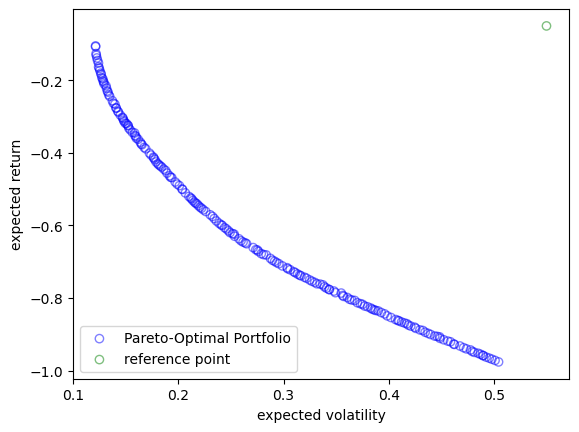

  Hypervolume@500: 0.284595
Run 1/1 - BinaryRandom_SBX - 600 gens


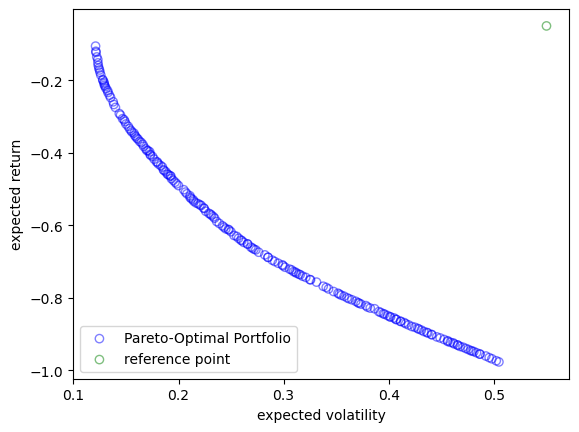

  Hypervolume@600: 0.284636
Run 1/1 - BinaryRandom_SBX - 700 gens


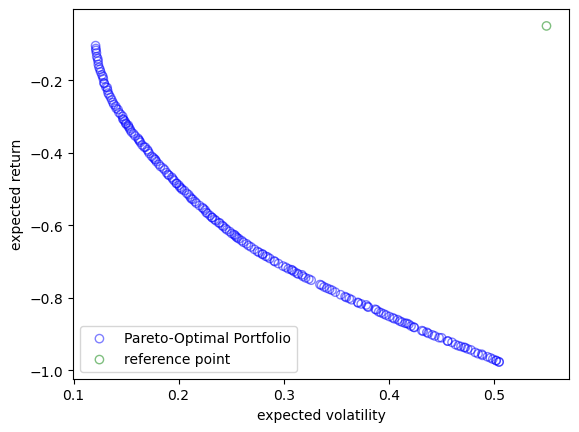

  Hypervolume@700: 0.284785
Run 1/1 - BinaryRandom_SBX - 800 gens


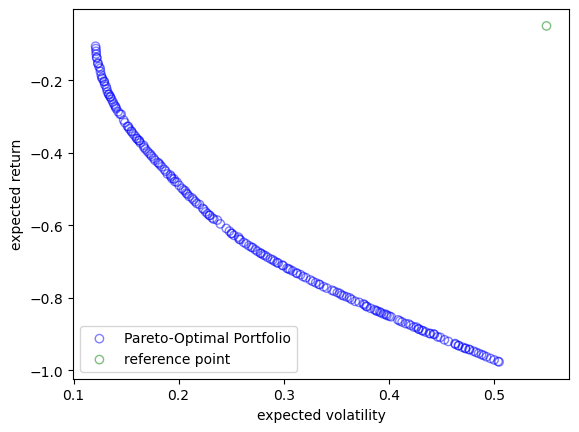

  Hypervolume@800: 0.284826
Run 1/1 - BinaryRandom_SBX - 900 gens


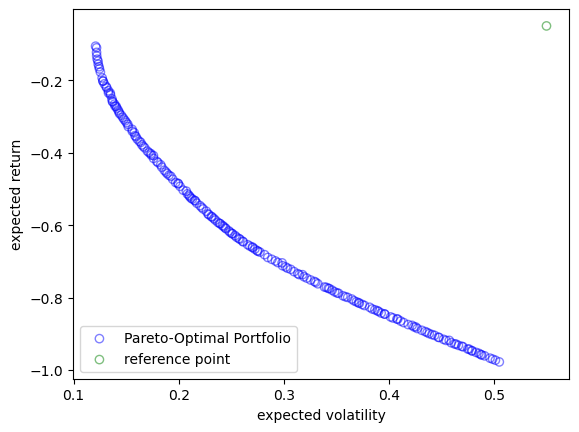

  Hypervolume@900: 0.284852
Run 1/1 - BinaryRandom_SBX - 1000 gens


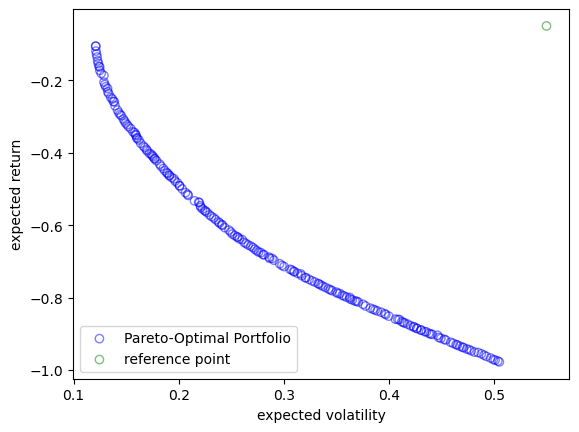

  Hypervolume@1000: 0.284793
Run 1/1 - BinaryRandom_SBX - 1100 gens


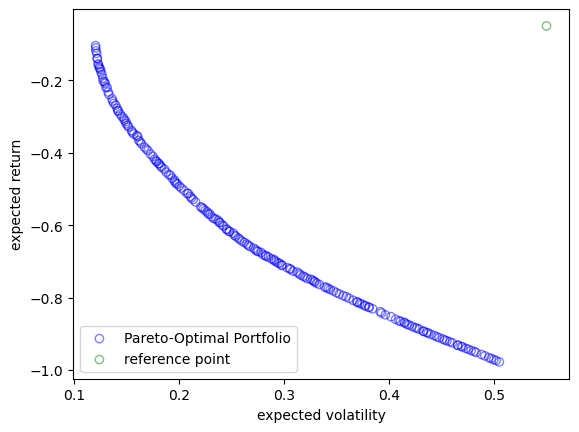

  Hypervolume@1100: 0.284905
Run 1/1 - BinaryRandom_SBX - 1200 gens


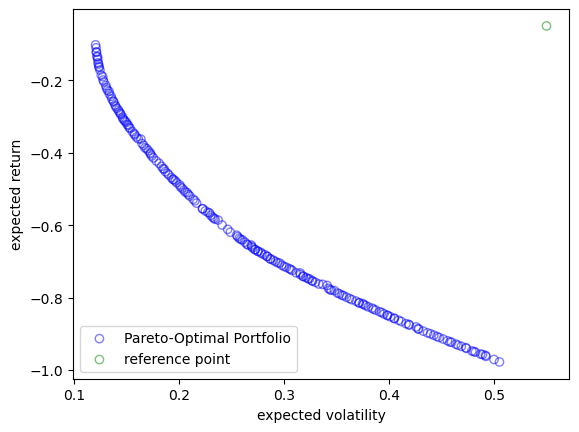

  Hypervolume@1200: 0.284791
Run 1/1 - BinaryRandom_SBX - 1300 gens


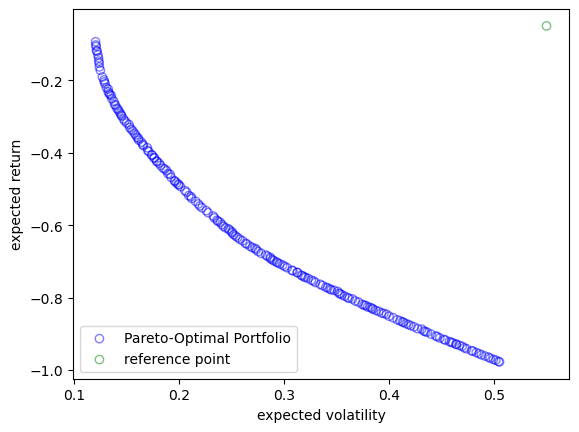

  Hypervolume@1300: 0.284919
Run 1/1 - BinaryRandom_SBX - 1400 gens


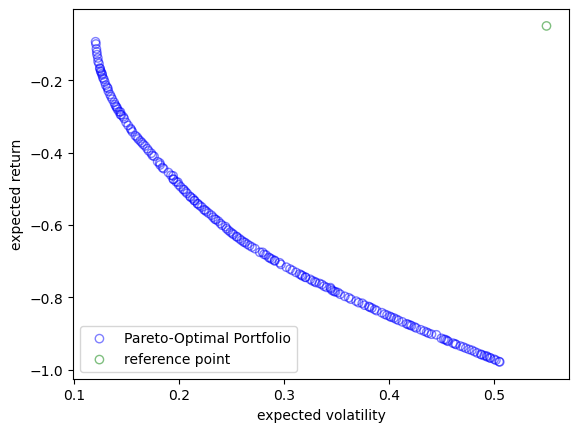

  Hypervolume@1400: 0.284930
Run 1/1 - BinaryRandom_SBX - 1500 gens


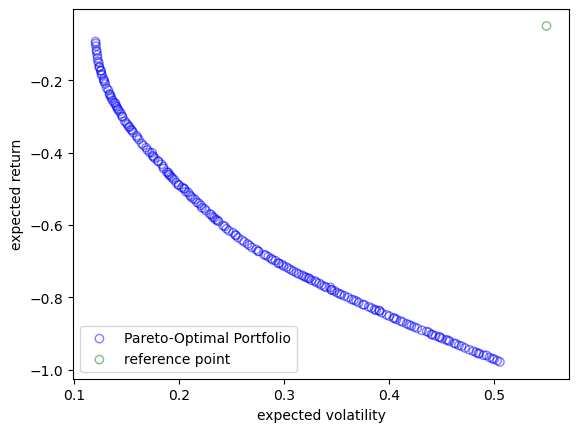

  Hypervolume@1500: 0.284942
Run 1/1 - BinaryRandom_SBX - 1600 gens


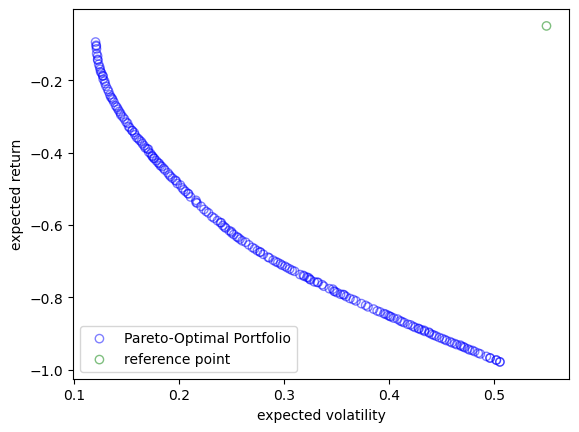

  Hypervolume@1600: 0.285022
Run 1/1 - BinaryRandom_SBX - 1700 gens


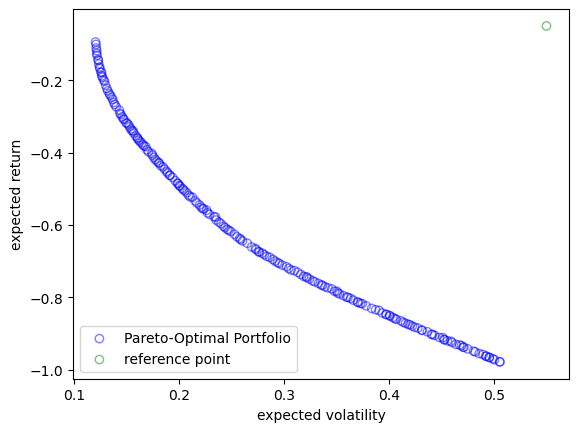

  Hypervolume@1700: 0.285025
Run 1/1 - BinaryRandom_SBX - 1800 gens


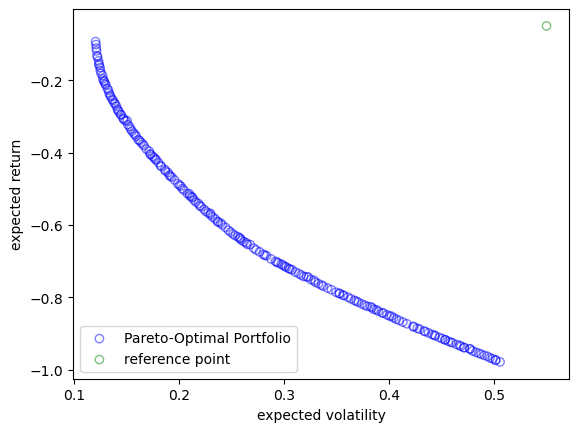

  Hypervolume@1800: 0.285131
Run 1/1 - BinaryRandom_SBX - 1900 gens


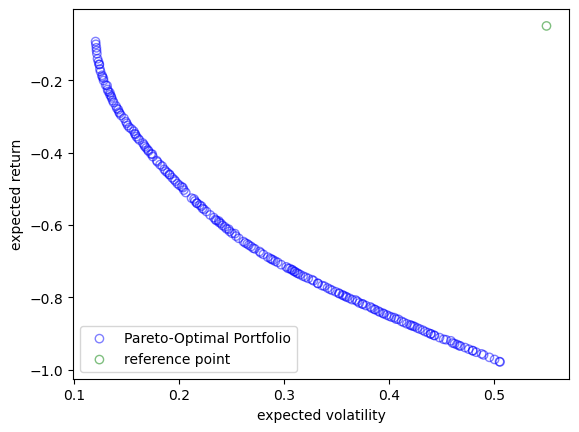

  Hypervolume@1900: 0.285074
Run 1/1 - BinaryRandom_SBX - 2000 gens


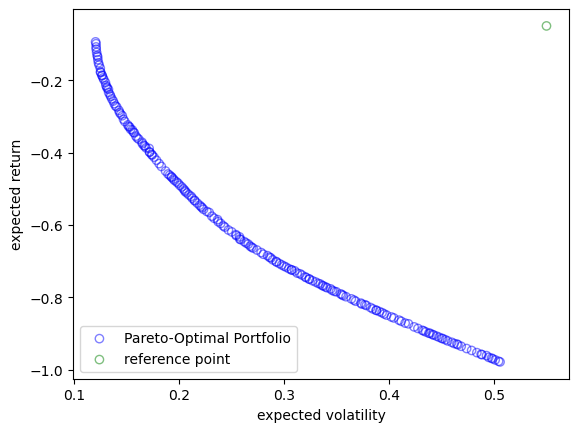

  Hypervolume@2000: 0.285069

Run 1/1 - BinaryRandom_TwoPt - 500 gens


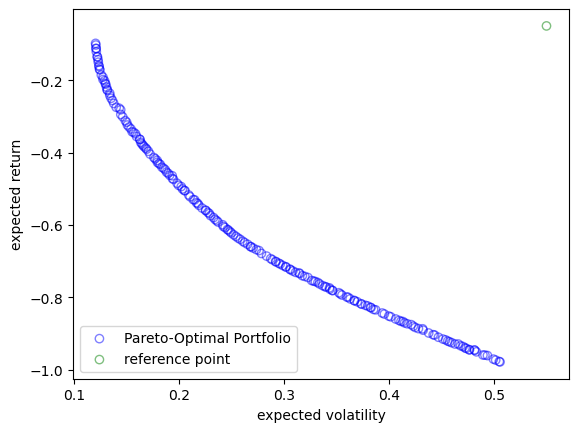

  Hypervolume@500: 0.284975
Run 1/1 - BinaryRandom_TwoPt - 600 gens


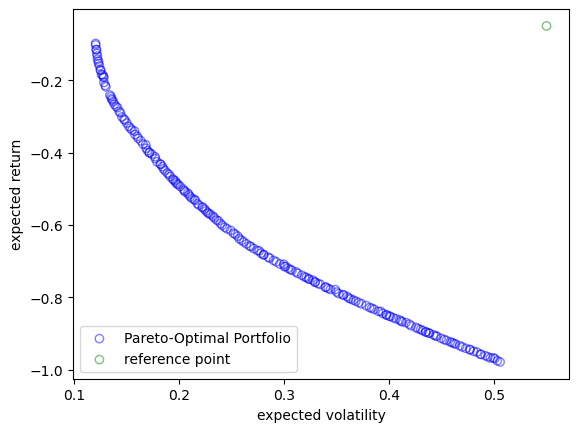

  Hypervolume@600: 0.284992
Run 1/1 - BinaryRandom_TwoPt - 700 gens


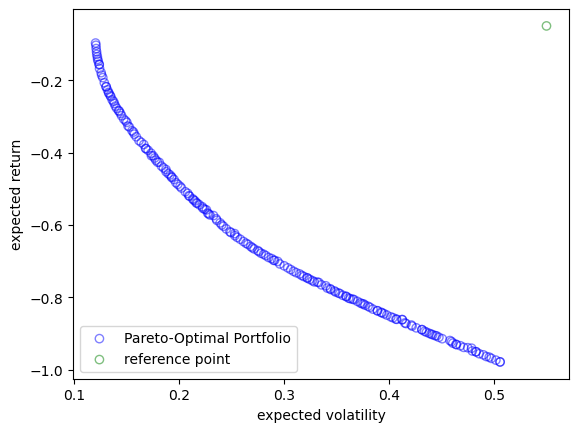

  Hypervolume@700: 0.285005
Run 1/1 - BinaryRandom_TwoPt - 800 gens


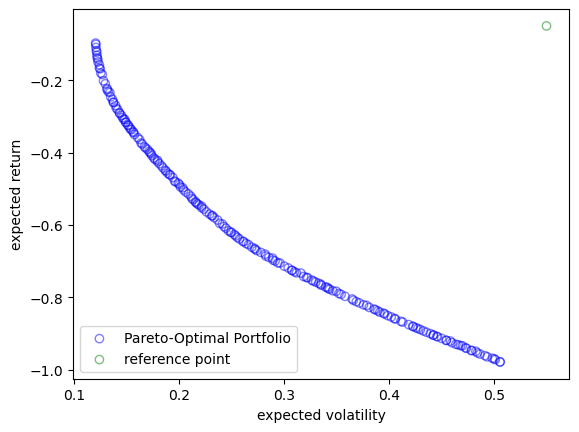

  Hypervolume@800: 0.285046
Run 1/1 - BinaryRandom_TwoPt - 900 gens


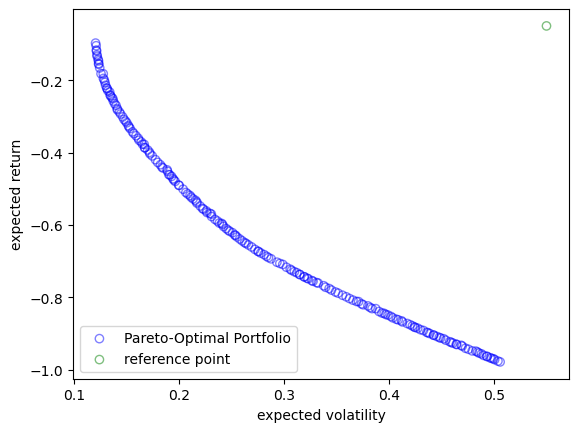

  Hypervolume@900: 0.285088
Run 1/1 - BinaryRandom_TwoPt - 1000 gens


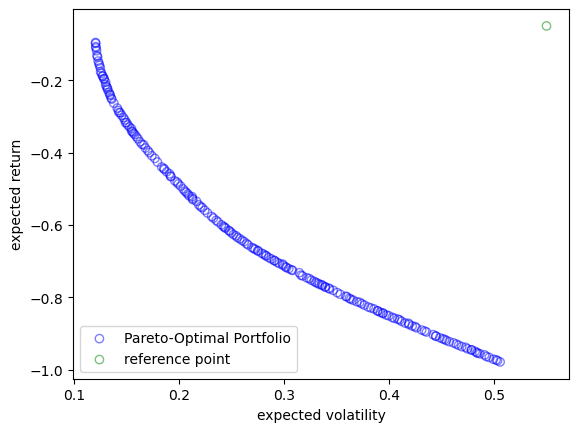

  Hypervolume@1000: 0.285117
Run 1/1 - BinaryRandom_TwoPt - 1100 gens


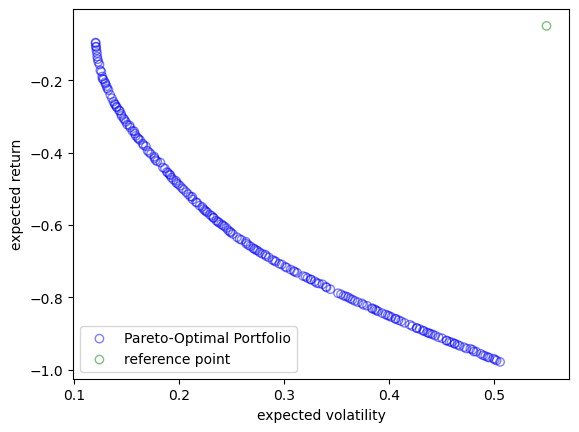

  Hypervolume@1100: 0.285058
Run 1/1 - BinaryRandom_TwoPt - 1200 gens


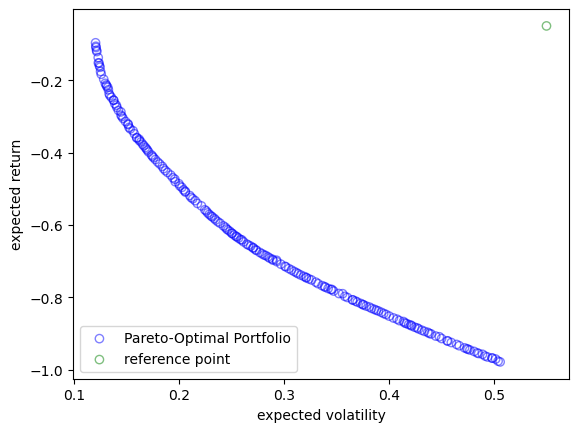

  Hypervolume@1200: 0.285137
Run 1/1 - BinaryRandom_TwoPt - 1300 gens


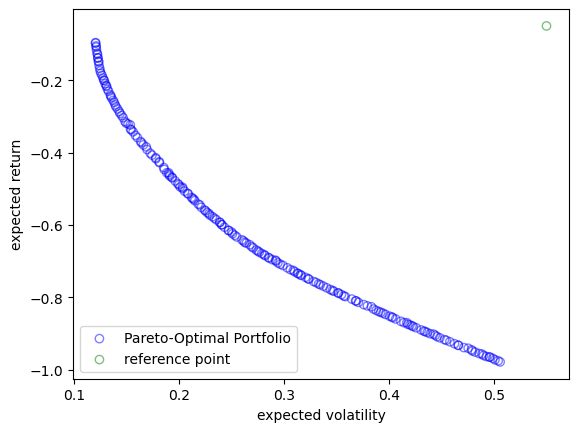

  Hypervolume@1300: 0.285053
Run 1/1 - BinaryRandom_TwoPt - 1400 gens


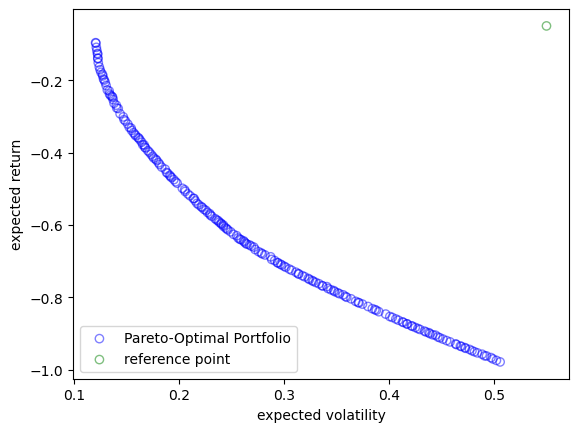

  Hypervolume@1400: 0.285127
Run 1/1 - BinaryRandom_TwoPt - 1500 gens


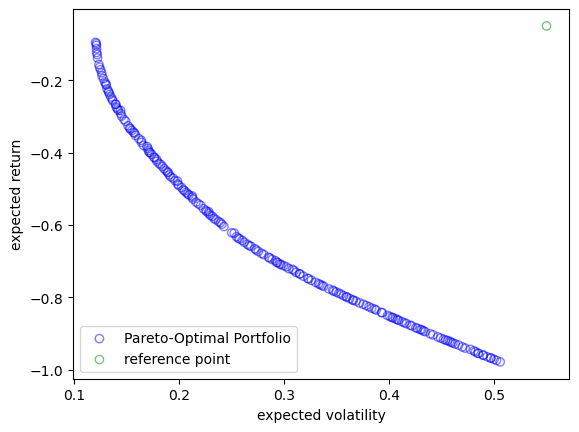

  Hypervolume@1500: 0.285093
Run 1/1 - BinaryRandom_TwoPt - 1600 gens


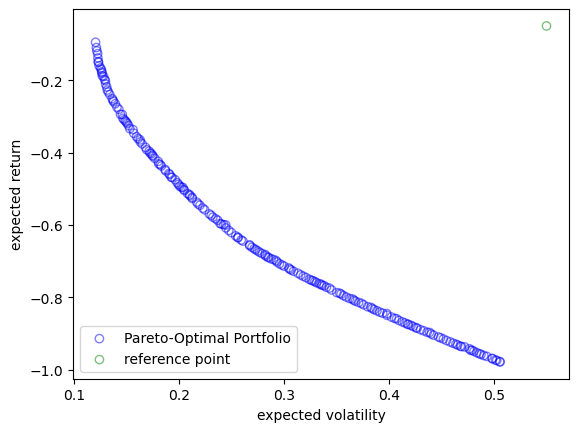

  Hypervolume@1600: 0.285061
Run 1/1 - BinaryRandom_TwoPt - 1700 gens


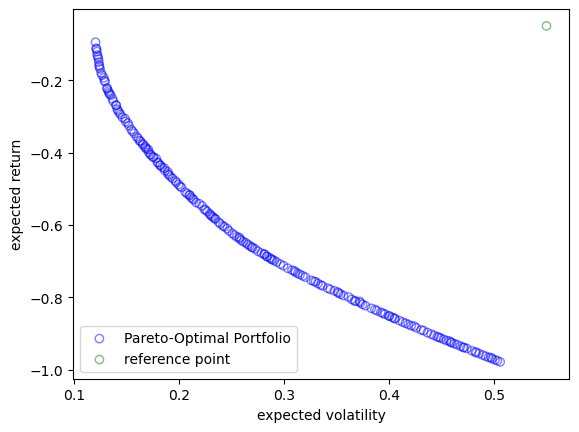

  Hypervolume@1700: 0.285204
Run 1/1 - BinaryRandom_TwoPt - 1800 gens


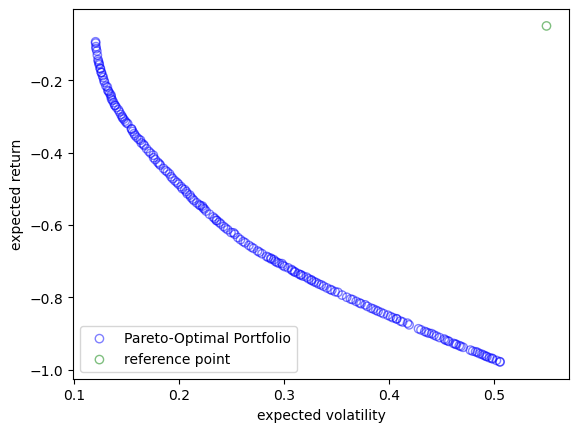

  Hypervolume@1800: 0.285189
Run 1/1 - BinaryRandom_TwoPt - 1900 gens


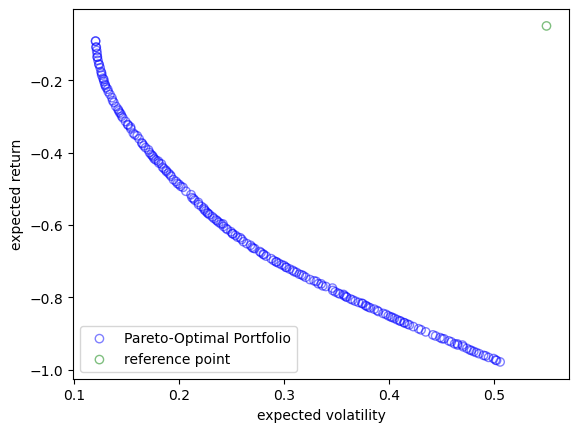

  Hypervolume@1900: 0.285094
Run 1/1 - BinaryRandom_TwoPt - 2000 gens


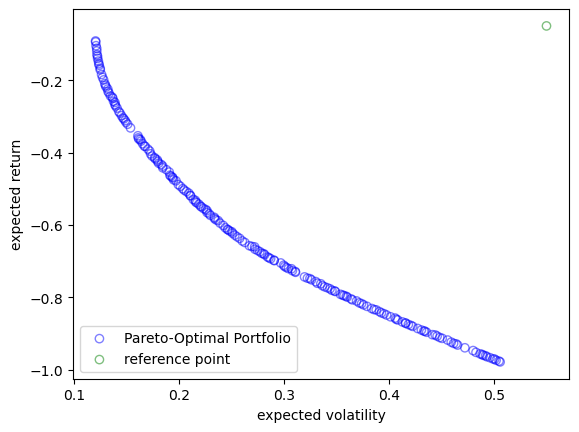

  Hypervolume@2000: 0.284967

Run 1/1 - BinaryRandom_Uniform - 500 gens


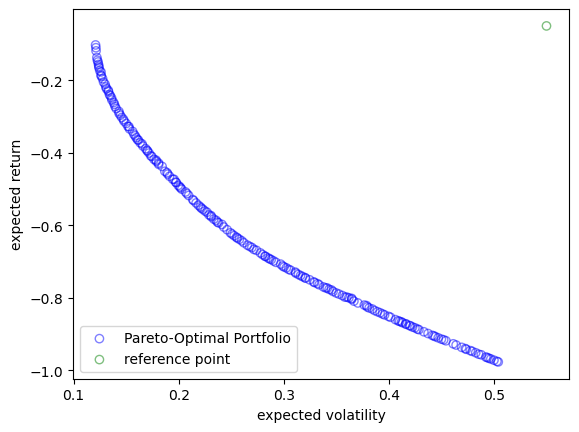

  Hypervolume@500: 0.285163
Run 1/1 - BinaryRandom_Uniform - 600 gens


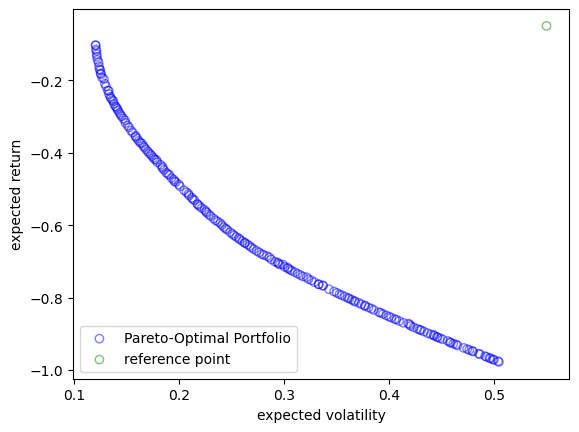

  Hypervolume@600: 0.285216
Run 1/1 - BinaryRandom_Uniform - 700 gens


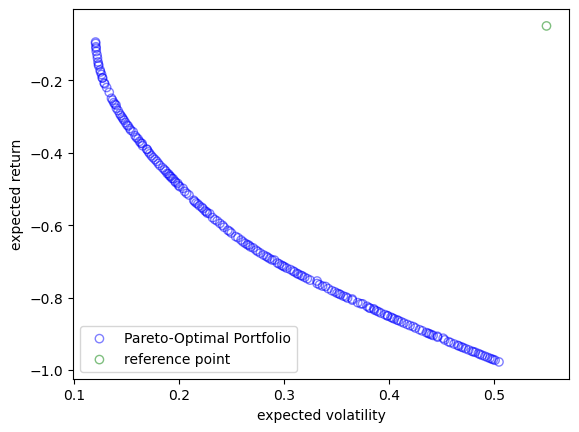

  Hypervolume@700: 0.285260
Run 1/1 - BinaryRandom_Uniform - 800 gens


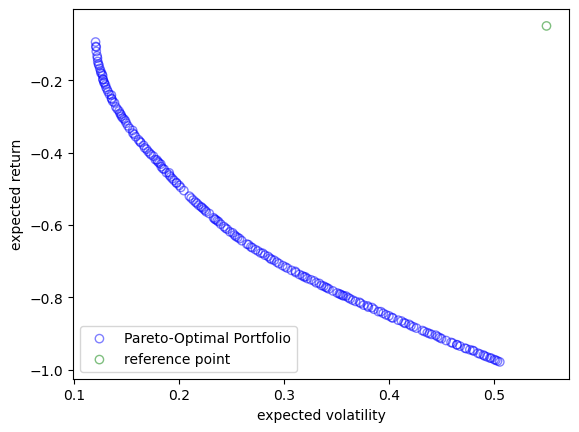

  Hypervolume@800: 0.285247
Run 1/1 - BinaryRandom_Uniform - 900 gens


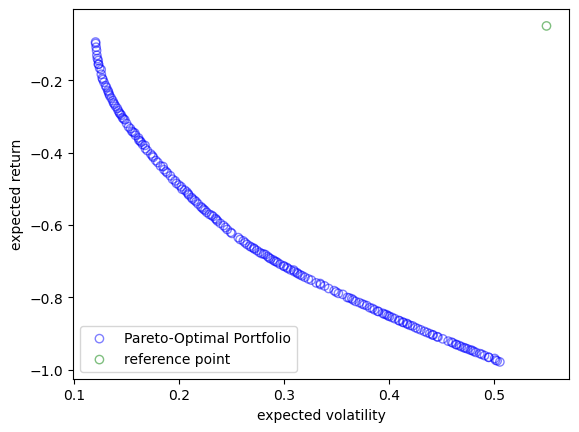

  Hypervolume@900: 0.285172
Run 1/1 - BinaryRandom_Uniform - 1000 gens


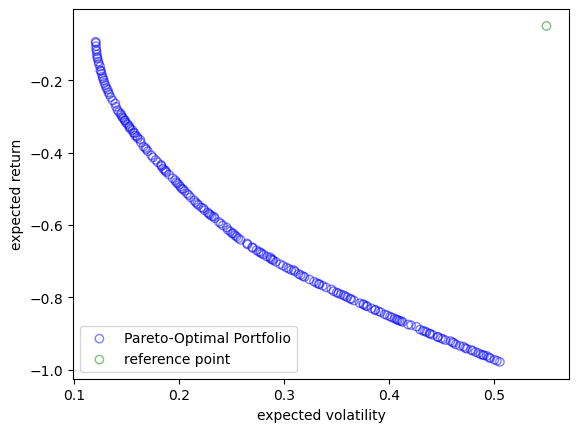

  Hypervolume@1000: 0.285198
Run 1/1 - BinaryRandom_Uniform - 1100 gens


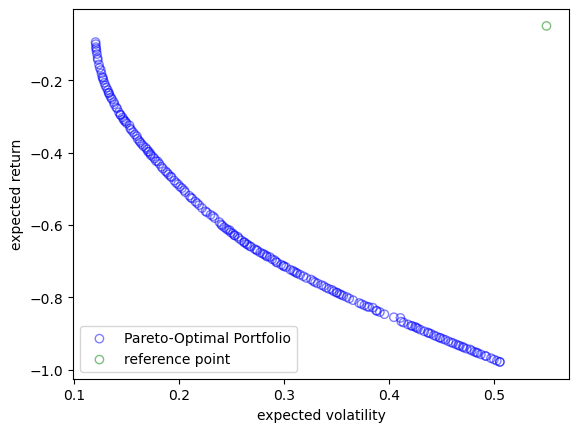

  Hypervolume@1100: 0.285264
Run 1/1 - BinaryRandom_Uniform - 1200 gens


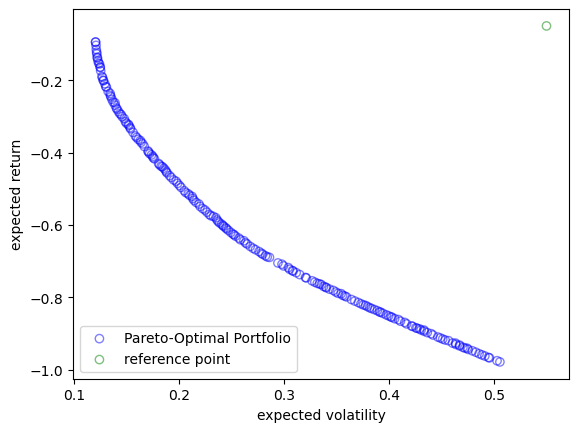

  Hypervolume@1200: 0.285222
Run 1/1 - BinaryRandom_Uniform - 1300 gens


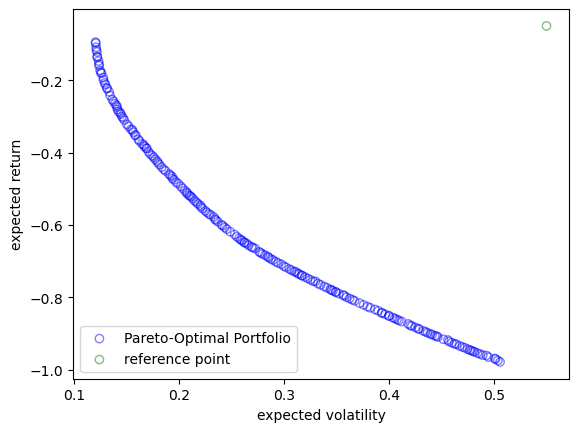

  Hypervolume@1300: 0.285256
Run 1/1 - BinaryRandom_Uniform - 1400 gens


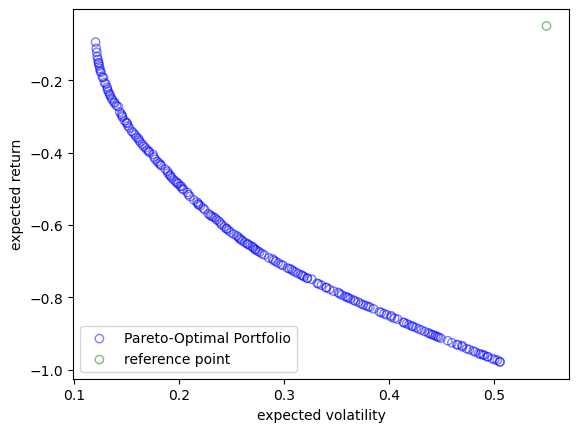

  Hypervolume@1400: 0.285155
Run 1/1 - BinaryRandom_Uniform - 1500 gens


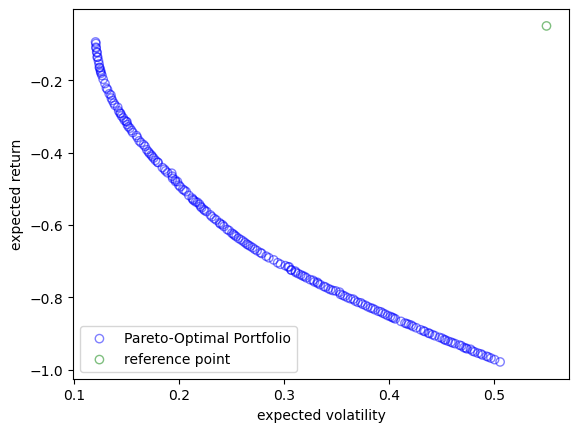

  Hypervolume@1500: 0.285264
Run 1/1 - BinaryRandom_Uniform - 1600 gens


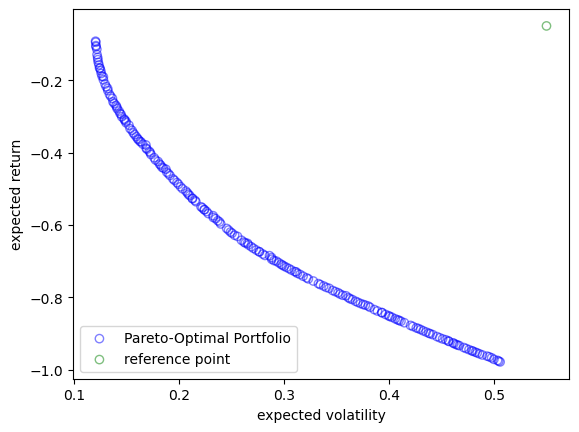

  Hypervolume@1600: 0.285213
Run 1/1 - BinaryRandom_Uniform - 1700 gens


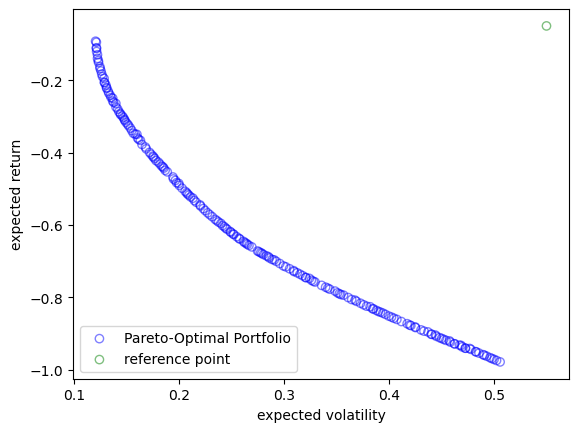

  Hypervolume@1700: 0.285152
Run 1/1 - BinaryRandom_Uniform - 1800 gens


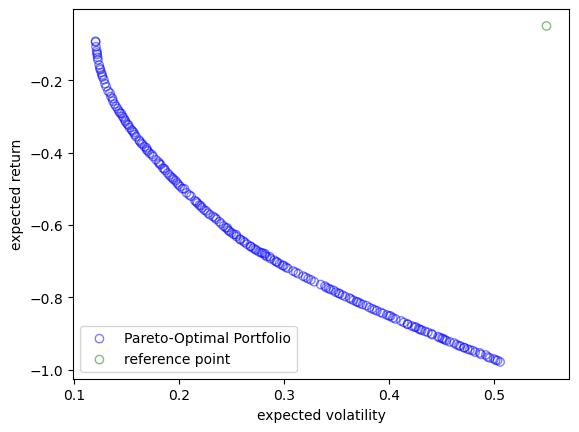

  Hypervolume@1800: 0.285240
Run 1/1 - BinaryRandom_Uniform - 1900 gens


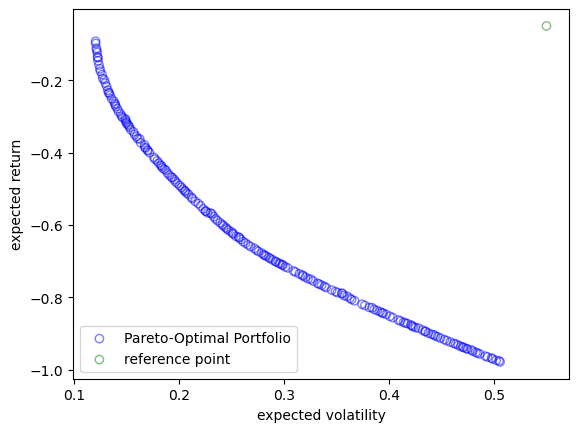

  Hypervolume@1900: 0.285222
Run 1/1 - BinaryRandom_Uniform - 2000 gens


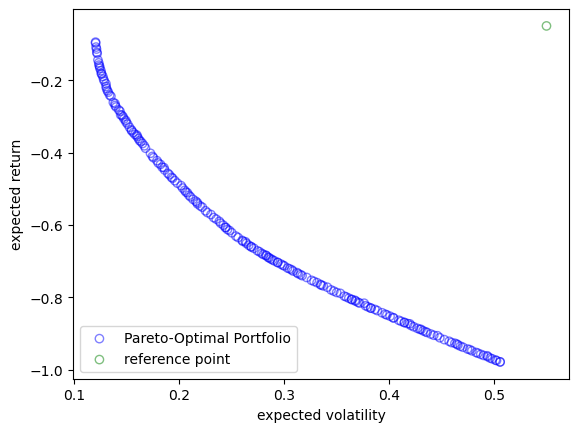

  Hypervolume@2000: 0.285183

Run 1/1 - FloatRandom_SBX - 500 gens


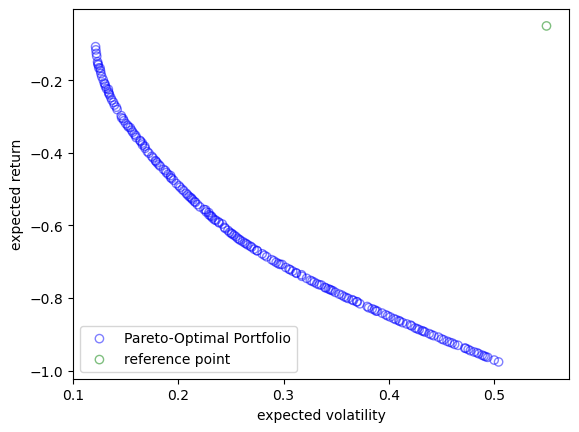

  Hypervolume@500: 0.284607
Run 1/1 - FloatRandom_SBX - 600 gens


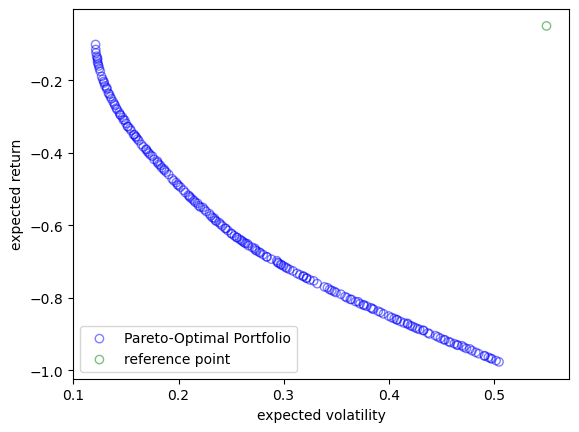

  Hypervolume@600: 0.284741
Run 1/1 - FloatRandom_SBX - 700 gens


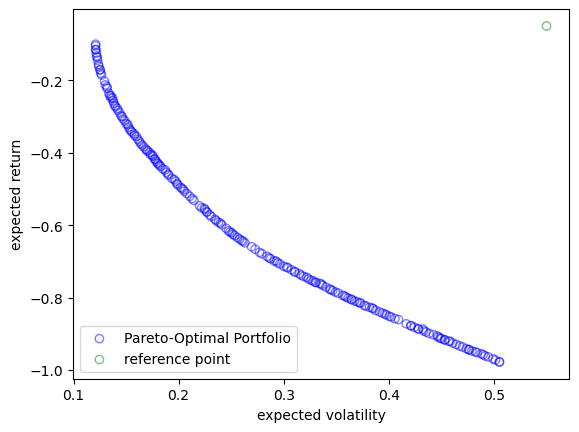

  Hypervolume@700: 0.284756
Run 1/1 - FloatRandom_SBX - 800 gens


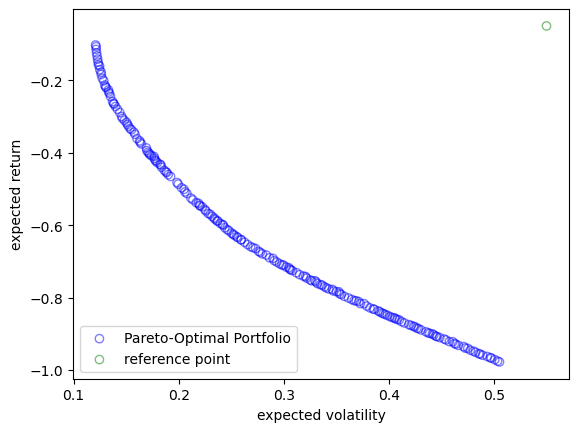

  Hypervolume@800: 0.284729
Run 1/1 - FloatRandom_SBX - 900 gens


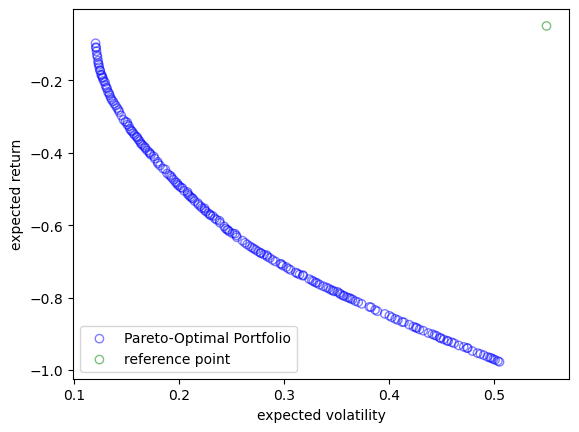

  Hypervolume@900: 0.284808
Run 1/1 - FloatRandom_SBX - 1000 gens


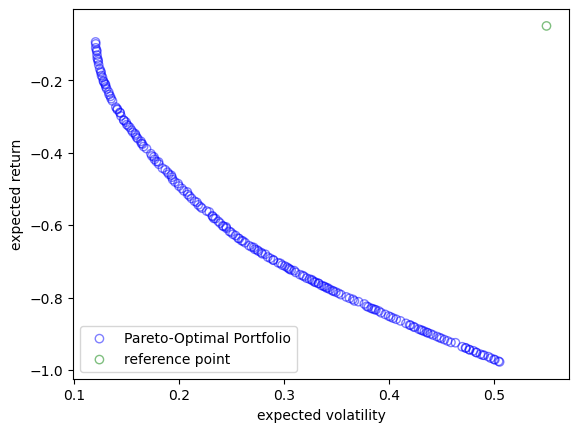

  Hypervolume@1000: 0.284852
Run 1/1 - FloatRandom_SBX - 1100 gens


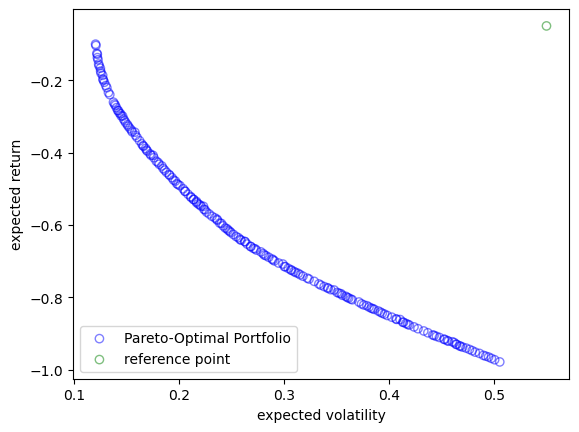

  Hypervolume@1100: 0.284985
Run 1/1 - FloatRandom_SBX - 1200 gens


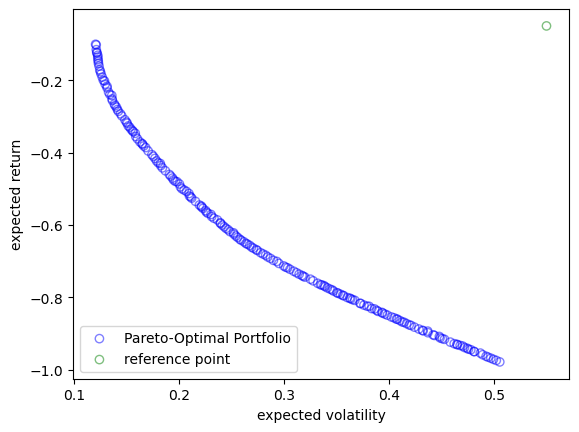

  Hypervolume@1200: 0.284938
Run 1/1 - FloatRandom_SBX - 1300 gens


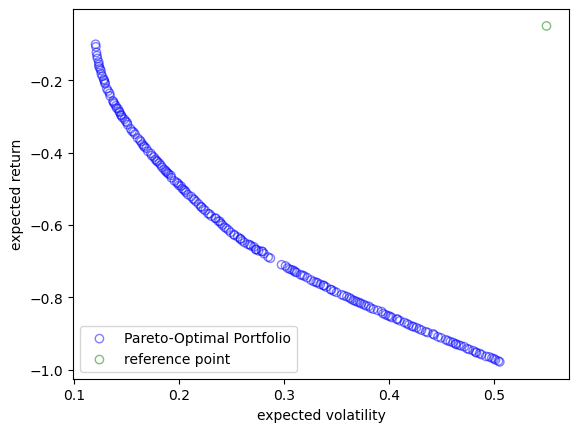

  Hypervolume@1300: 0.284807
Run 1/1 - FloatRandom_SBX - 1400 gens


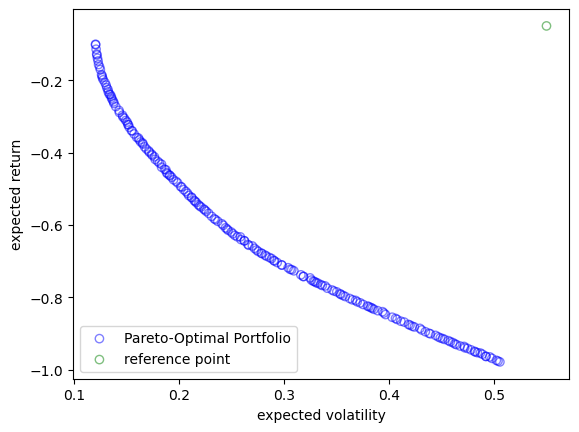

  Hypervolume@1400: 0.284872
Run 1/1 - FloatRandom_SBX - 1500 gens


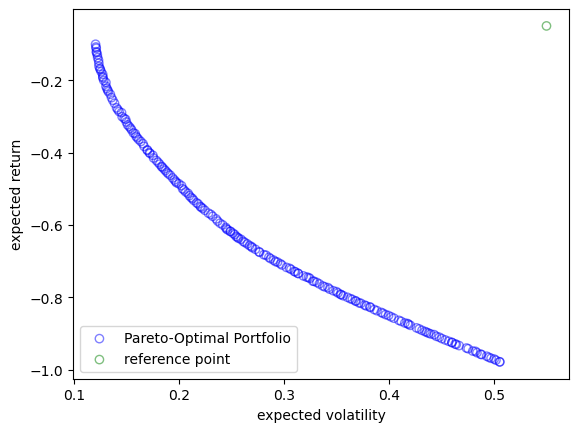

  Hypervolume@1500: 0.284937
Run 1/1 - FloatRandom_SBX - 1600 gens


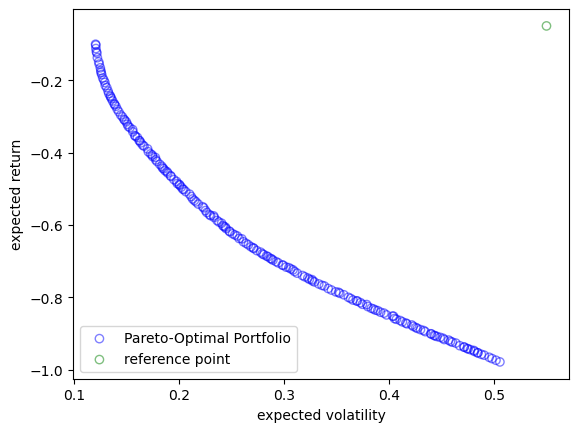

  Hypervolume@1600: 0.284931
Run 1/1 - FloatRandom_SBX - 1700 gens


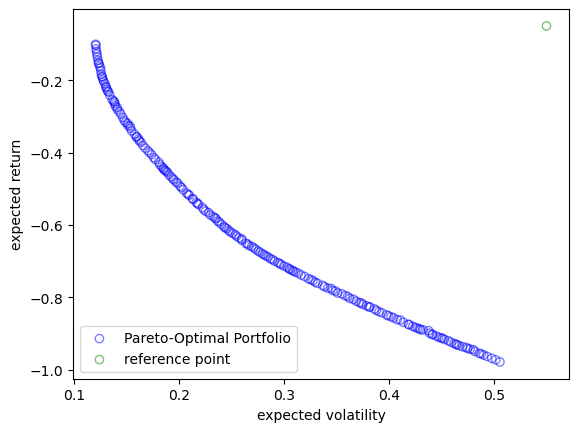

  Hypervolume@1700: 0.284995
Run 1/1 - FloatRandom_SBX - 1800 gens


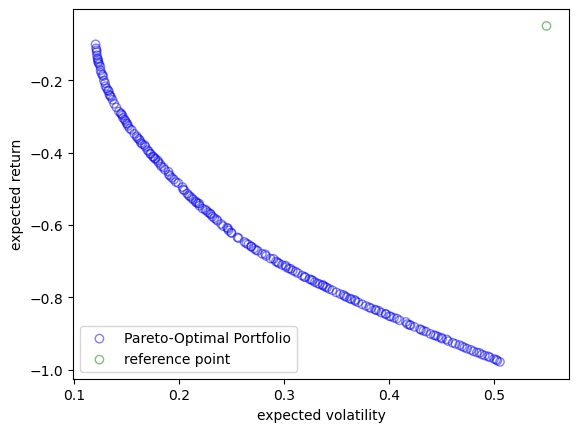

  Hypervolume@1800: 0.284932
Run 1/1 - FloatRandom_SBX - 1900 gens


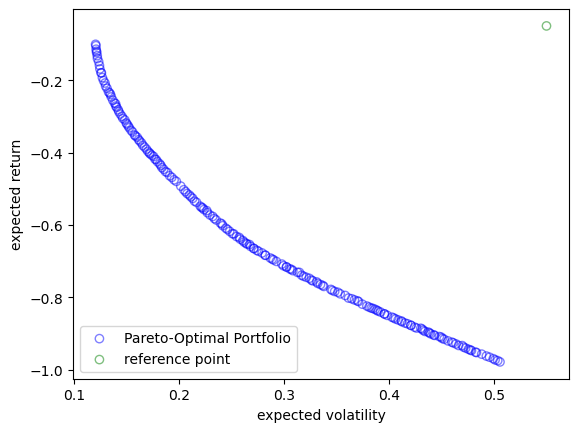

  Hypervolume@1900: 0.284991
Run 1/1 - FloatRandom_SBX - 2000 gens


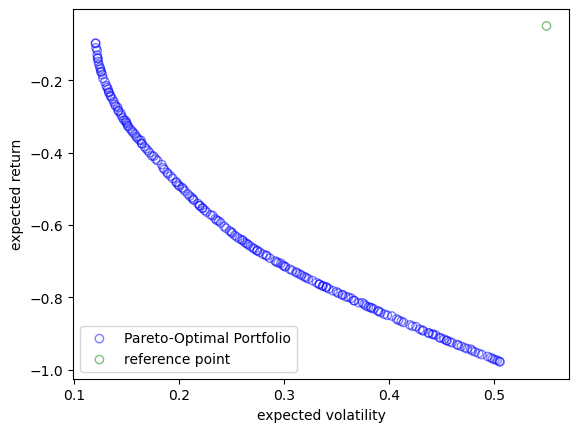

  Hypervolume@2000: 0.285008

Run 1/1 - FloatRandom_TwoPt - 500 gens


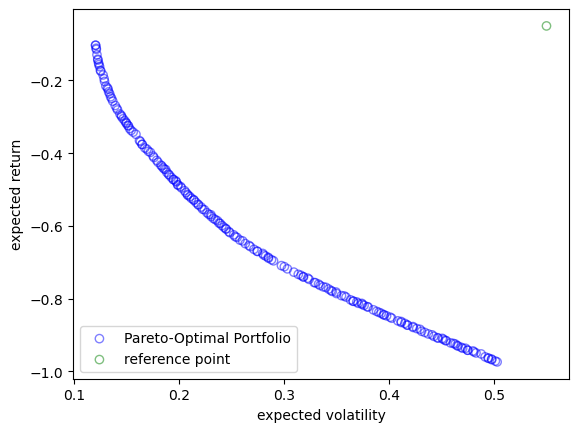

  Hypervolume@500: 0.284249
Run 1/1 - FloatRandom_TwoPt - 600 gens


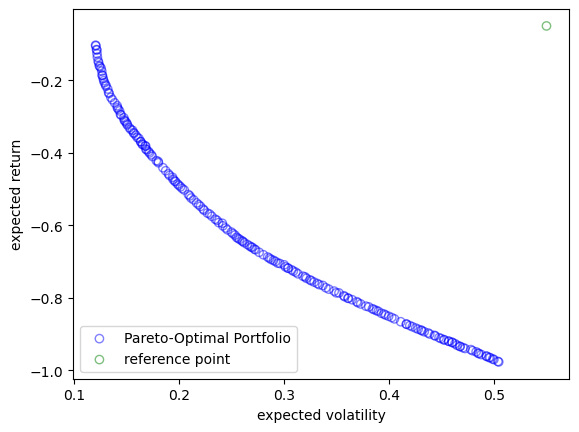

  Hypervolume@600: 0.284579
Run 1/1 - FloatRandom_TwoPt - 700 gens


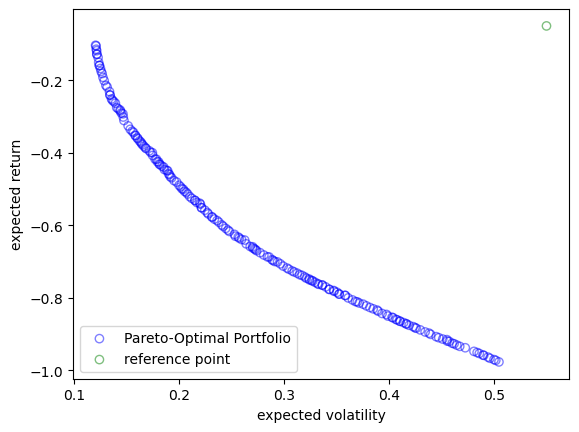

  Hypervolume@700: 0.284567
Run 1/1 - FloatRandom_TwoPt - 800 gens


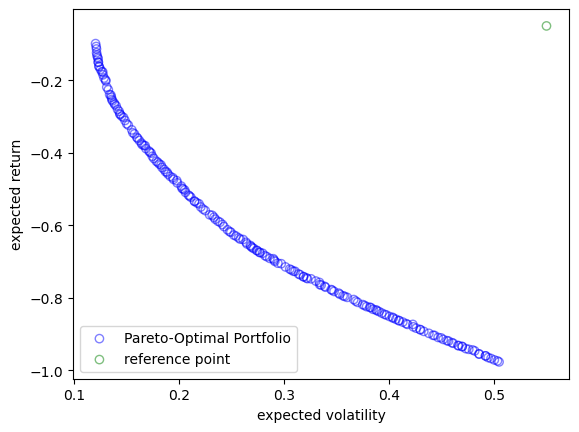

  Hypervolume@800: 0.284643
Run 1/1 - FloatRandom_TwoPt - 900 gens


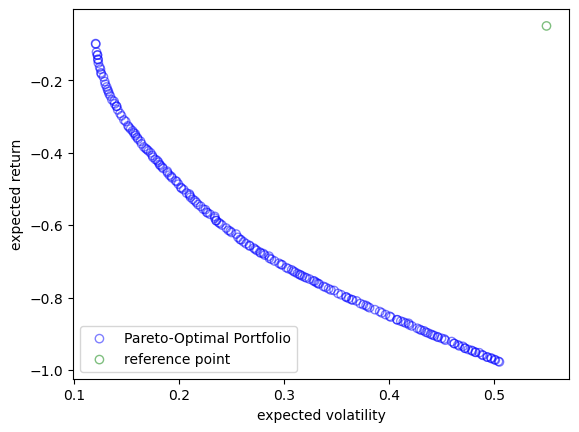

  Hypervolume@900: 0.284868
Run 1/1 - FloatRandom_TwoPt - 1000 gens


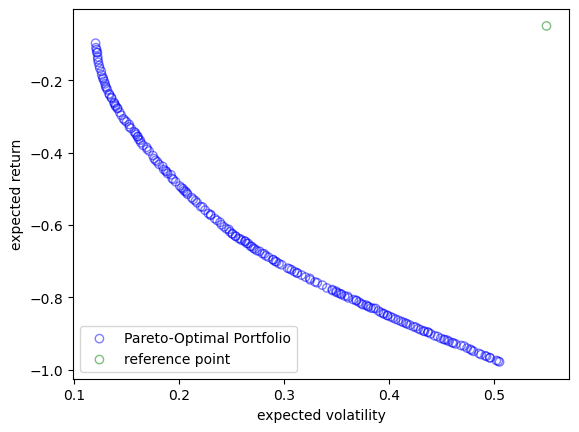

  Hypervolume@1000: 0.284794
Run 1/1 - FloatRandom_TwoPt - 1100 gens


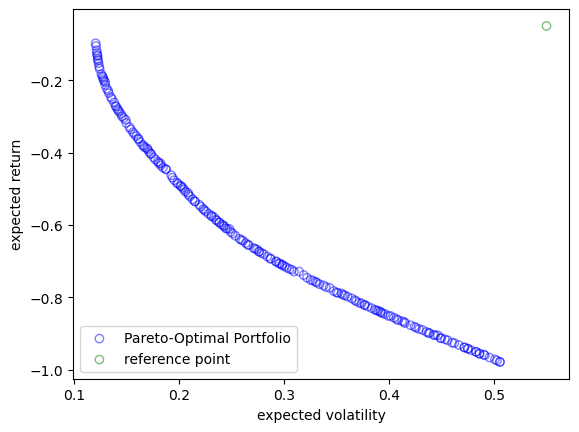

  Hypervolume@1100: 0.284825
Run 1/1 - FloatRandom_TwoPt - 1200 gens


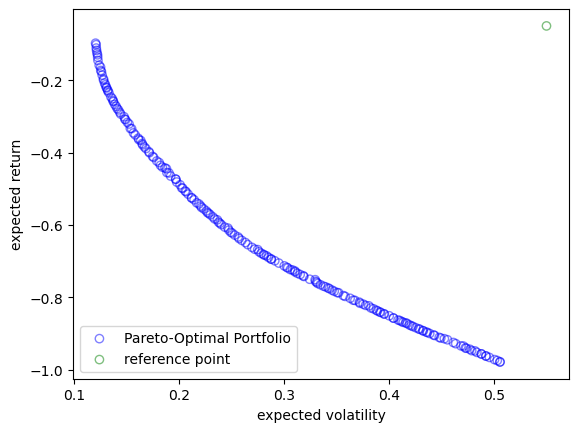

  Hypervolume@1200: 0.284876
Run 1/1 - FloatRandom_TwoPt - 1300 gens


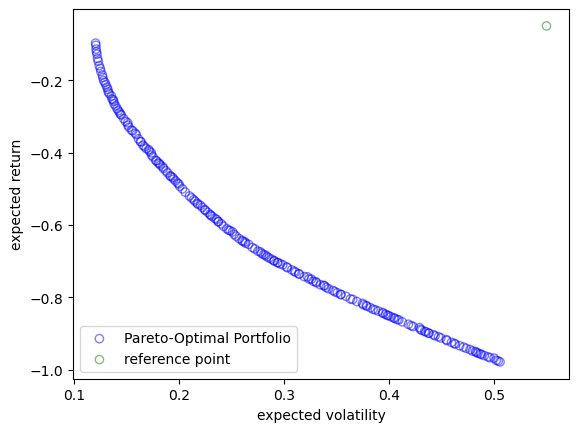

  Hypervolume@1300: 0.285045
Run 1/1 - FloatRandom_TwoPt - 1400 gens


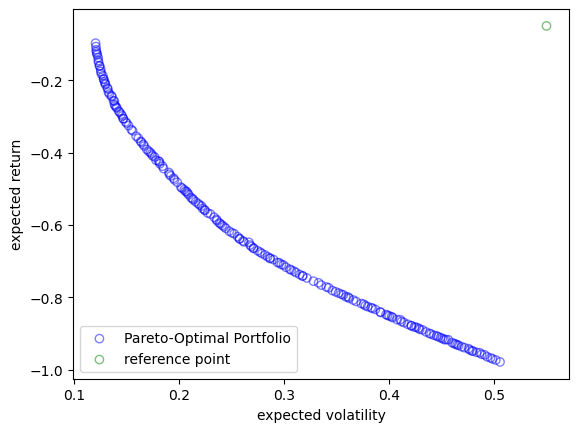

  Hypervolume@1400: 0.284916
Run 1/1 - FloatRandom_TwoPt - 1500 gens


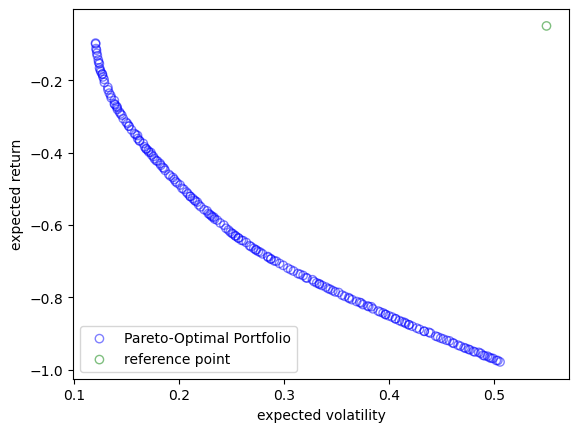

  Hypervolume@1500: 0.285008
Run 1/1 - FloatRandom_TwoPt - 1600 gens


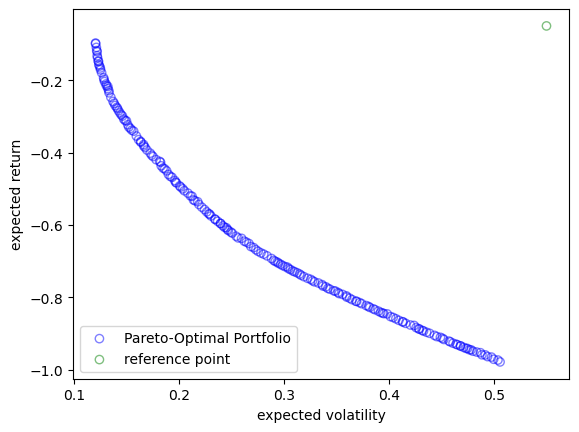

  Hypervolume@1600: 0.284984
Run 1/1 - FloatRandom_TwoPt - 1700 gens


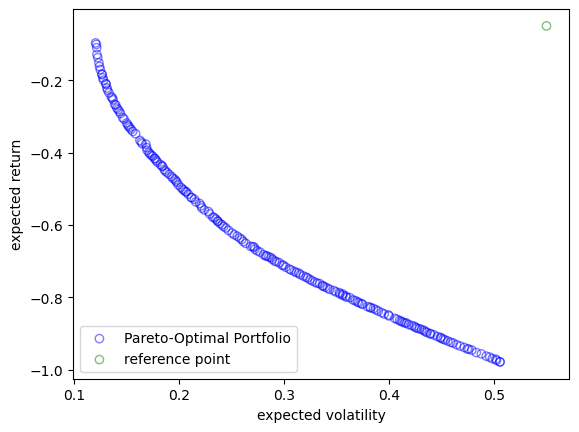

  Hypervolume@1700: 0.285041
Run 1/1 - FloatRandom_TwoPt - 1800 gens


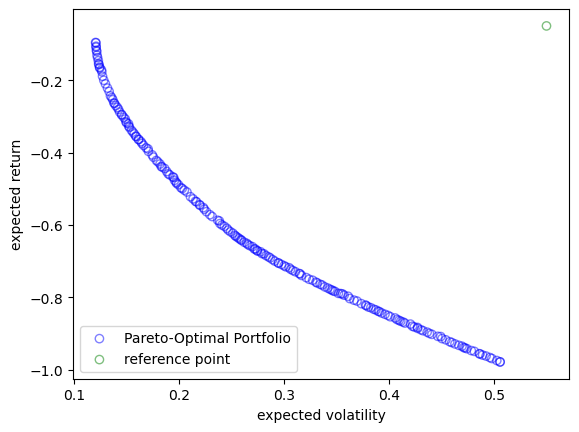

  Hypervolume@1800: 0.285006
Run 1/1 - FloatRandom_TwoPt - 1900 gens


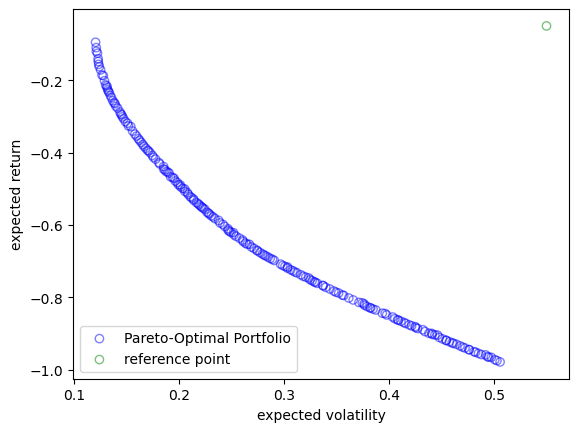

  Hypervolume@1900: 0.285068
Run 1/1 - FloatRandom_TwoPt - 2000 gens


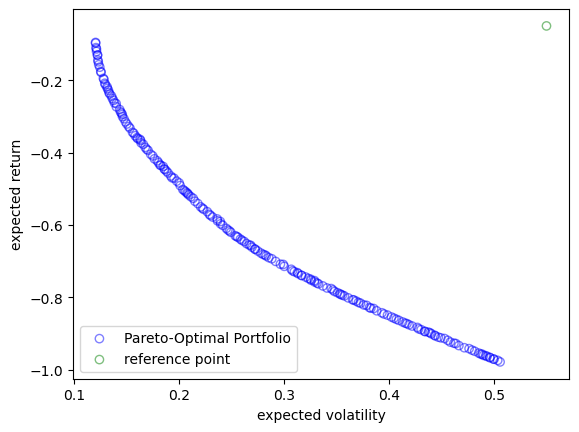

  Hypervolume@2000: 0.285052

Run 1/1 - FloatRandom_Uniform - 500 gens


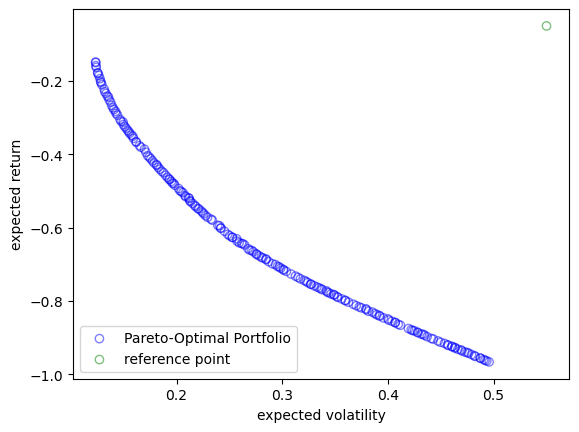

  Hypervolume@500: 0.284006
Run 1/1 - FloatRandom_Uniform - 600 gens


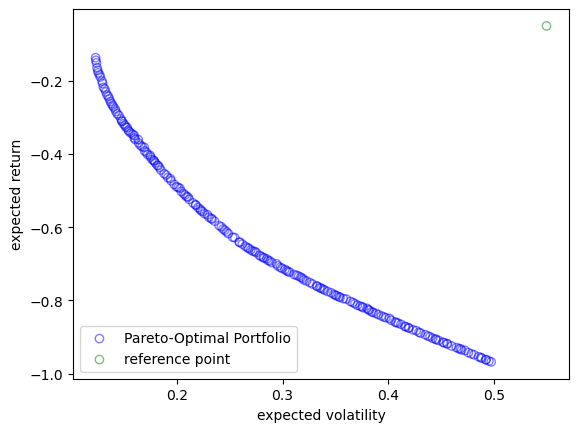

  Hypervolume@600: 0.284307
Run 1/1 - FloatRandom_Uniform - 700 gens


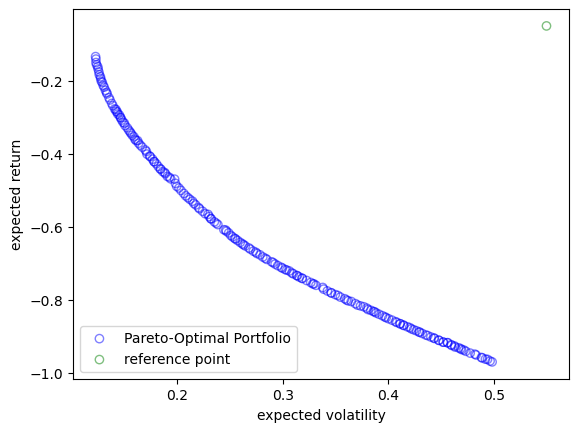

  Hypervolume@700: 0.284441
Run 1/1 - FloatRandom_Uniform - 800 gens


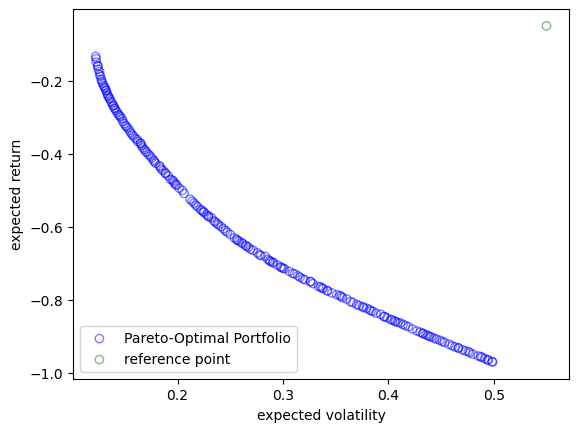

  Hypervolume@800: 0.284526
Run 1/1 - FloatRandom_Uniform - 900 gens


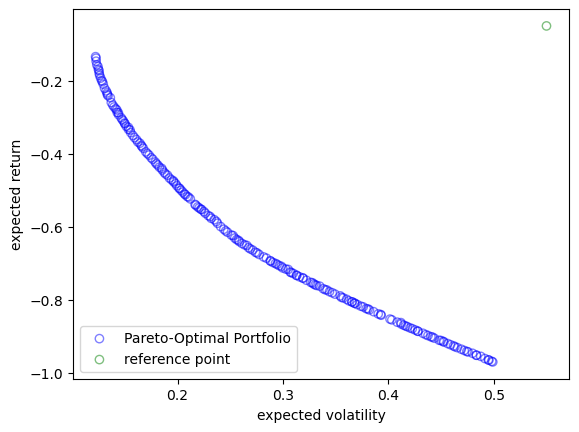

  Hypervolume@900: 0.284572
Run 1/1 - FloatRandom_Uniform - 1000 gens


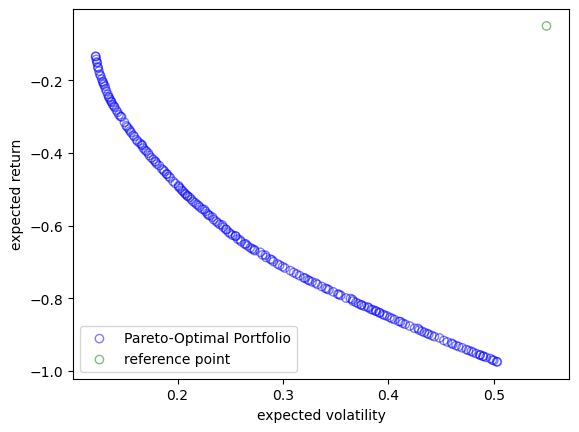

  Hypervolume@1000: 0.284858
Run 1/1 - FloatRandom_Uniform - 1100 gens


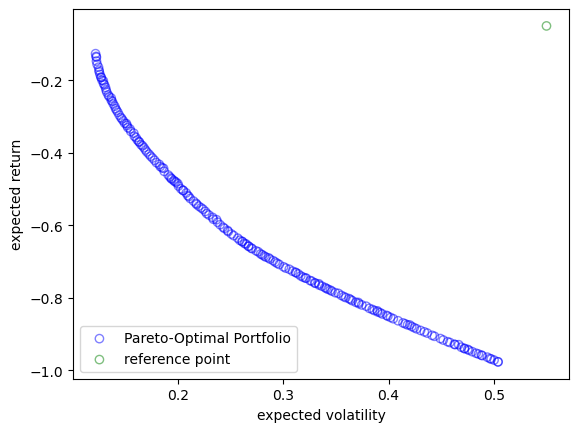

  Hypervolume@1100: 0.284938
Run 1/1 - FloatRandom_Uniform - 1200 gens


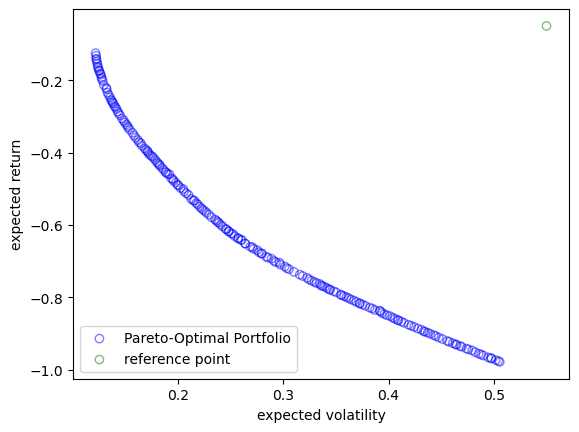

  Hypervolume@1200: 0.285087
Run 1/1 - FloatRandom_Uniform - 1300 gens


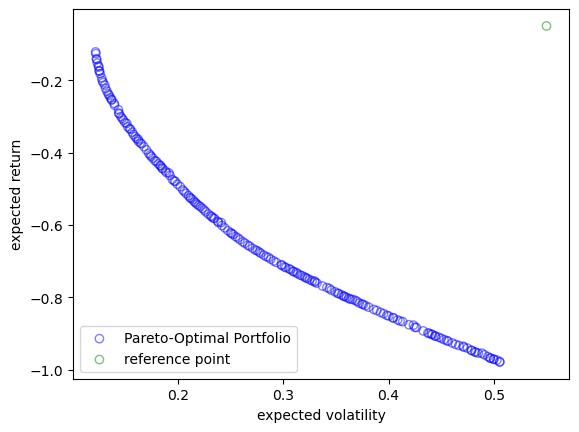

  Hypervolume@1300: 0.285031
Run 1/1 - FloatRandom_Uniform - 1400 gens


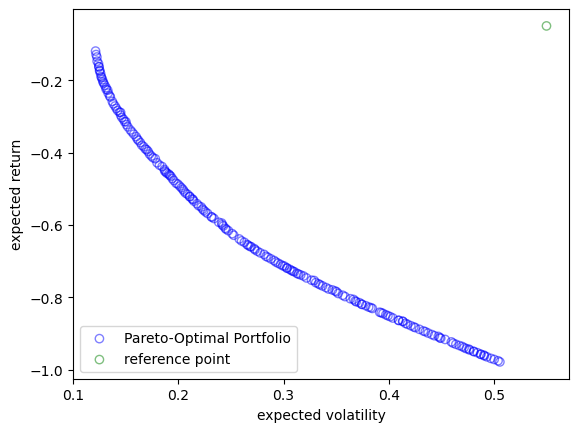

  Hypervolume@1400: 0.285054
Run 1/1 - FloatRandom_Uniform - 1500 gens


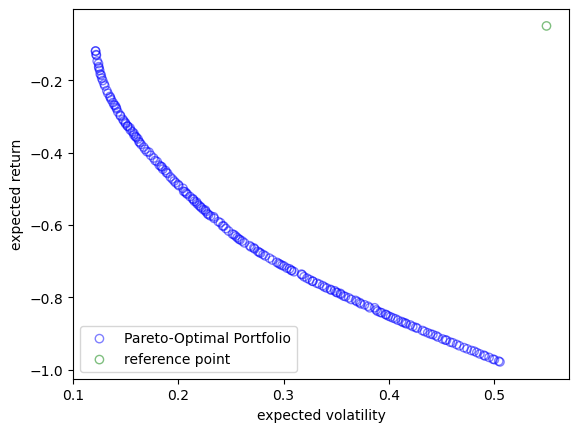

  Hypervolume@1500: 0.285122
Run 1/1 - FloatRandom_Uniform - 1600 gens


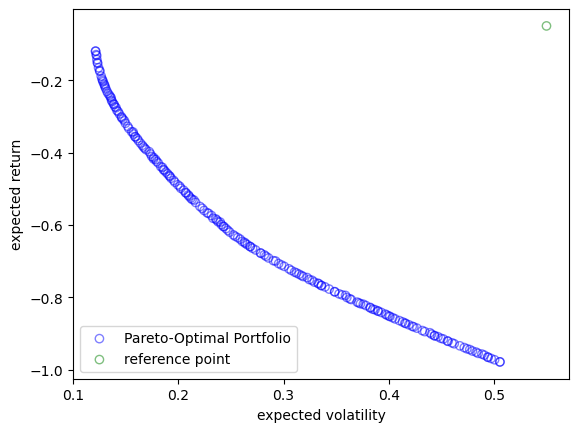

  Hypervolume@1600: 0.285183
Run 1/1 - FloatRandom_Uniform - 1700 gens


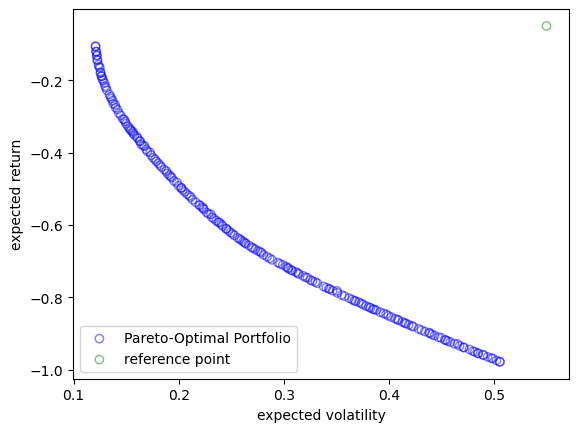

  Hypervolume@1700: 0.285243
Run 1/1 - FloatRandom_Uniform - 1800 gens


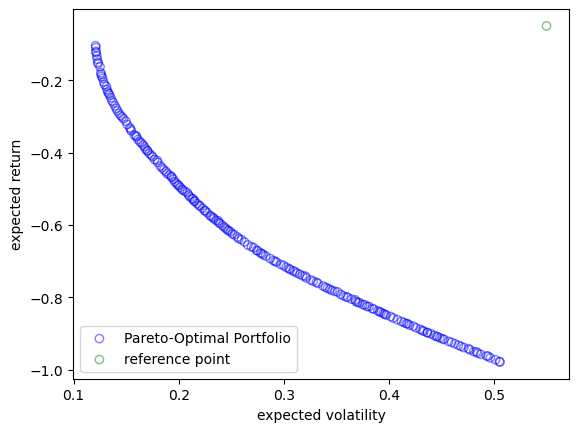

  Hypervolume@1800: 0.285208
Run 1/1 - FloatRandom_Uniform - 1900 gens


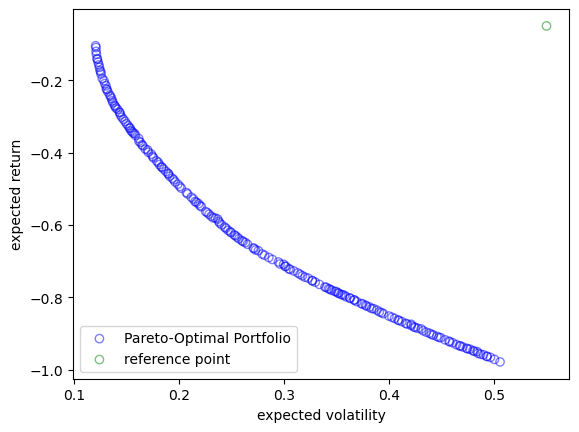

  Hypervolume@1900: 0.285119
Run 1/1 - FloatRandom_Uniform - 2000 gens


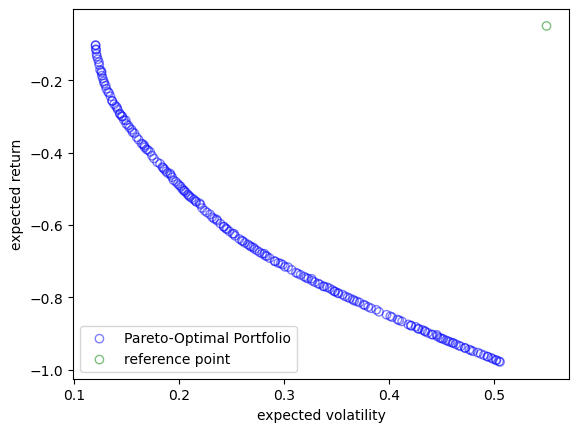

  Hypervolume@2000: 0.285134

Run 1/1 - LHS_SBX - 500 gens


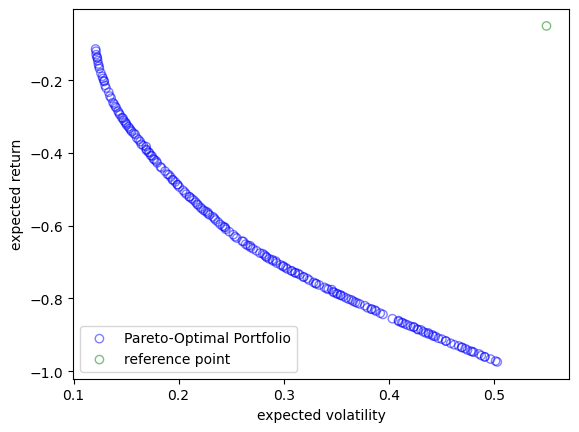

  Hypervolume@500: 0.284564
Run 1/1 - LHS_SBX - 600 gens


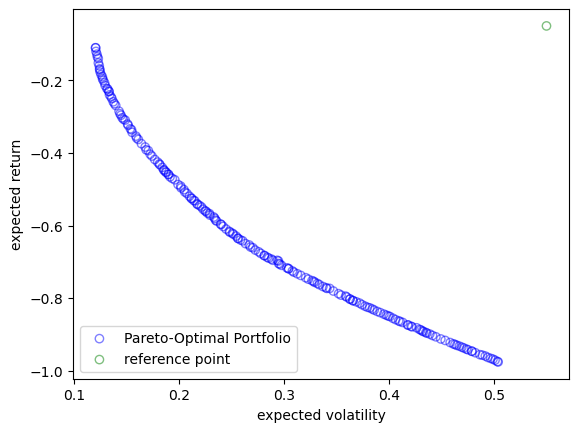

  Hypervolume@600: 0.284647
Run 1/1 - LHS_SBX - 700 gens


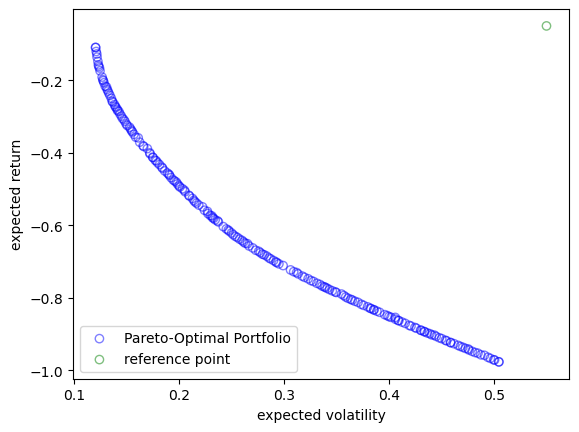

  Hypervolume@700: 0.284970
Run 1/1 - LHS_SBX - 800 gens


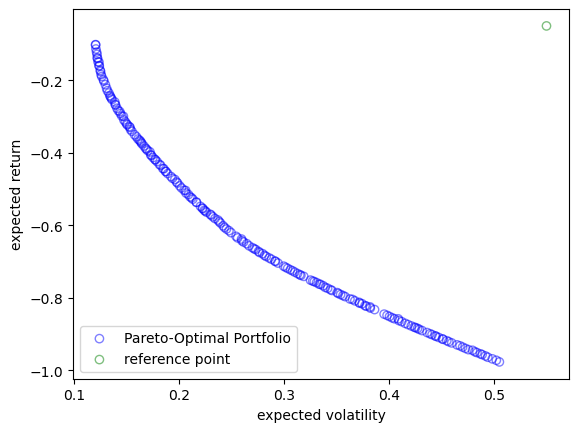

  Hypervolume@800: 0.284933
Run 1/1 - LHS_SBX - 900 gens


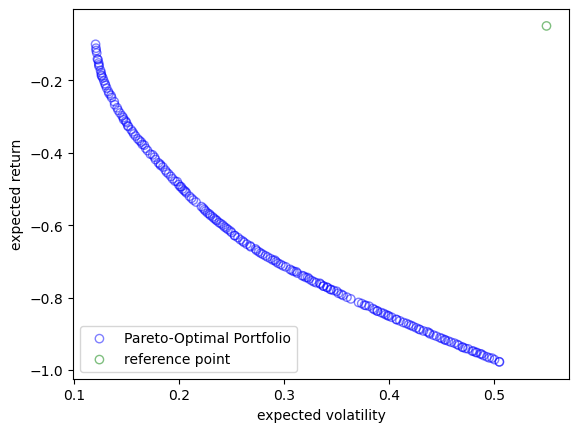

  Hypervolume@900: 0.284886
Run 1/1 - LHS_SBX - 1000 gens


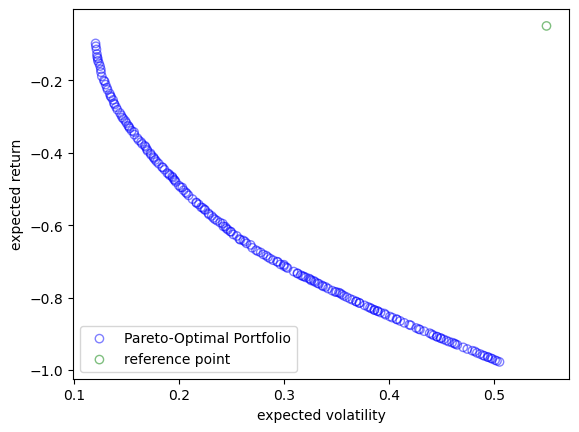

  Hypervolume@1000: 0.284950
Run 1/1 - LHS_SBX - 1100 gens


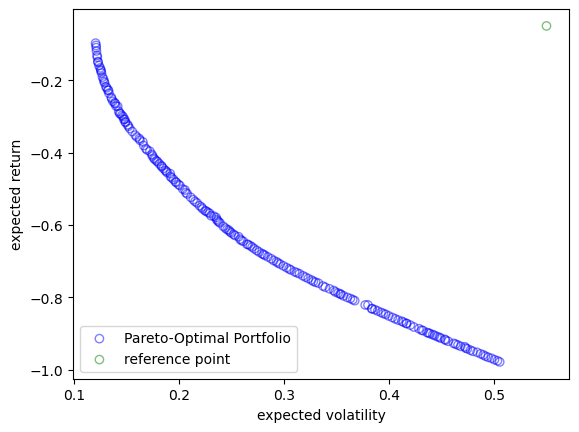

  Hypervolume@1100: 0.284934
Run 1/1 - LHS_SBX - 1200 gens


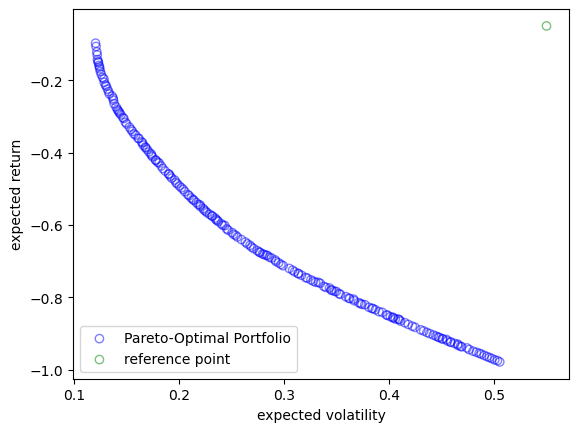

  Hypervolume@1200: 0.284952
Run 1/1 - LHS_SBX - 1300 gens


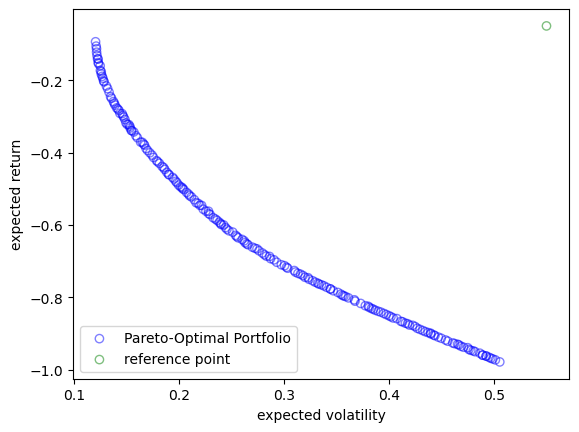

  Hypervolume@1300: 0.284871
Run 1/1 - LHS_SBX - 1400 gens


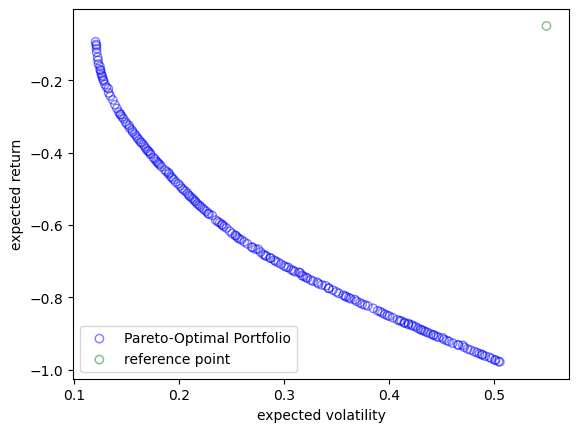

  Hypervolume@1400: 0.284981
Run 1/1 - LHS_SBX - 1500 gens


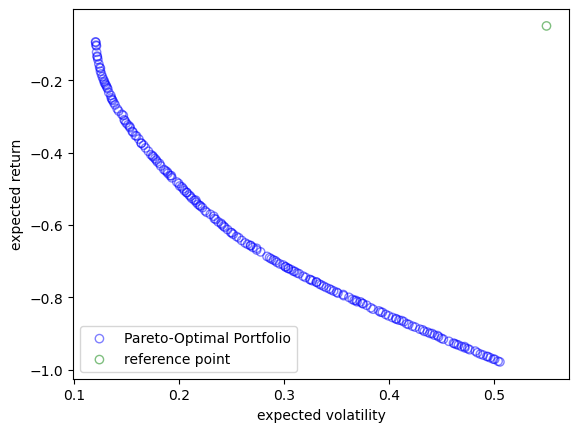

  Hypervolume@1500: 0.284919
Run 1/1 - LHS_SBX - 1600 gens


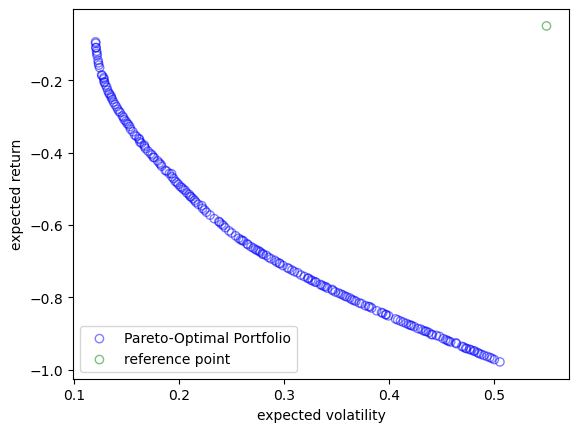

  Hypervolume@1600: 0.284948
Run 1/1 - LHS_SBX - 1700 gens


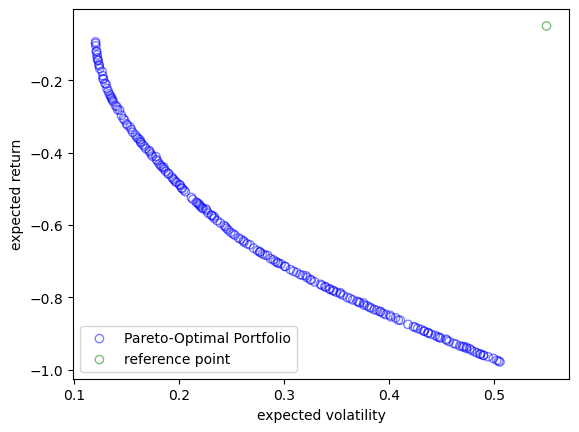

  Hypervolume@1700: 0.284917
Run 1/1 - LHS_SBX - 1800 gens


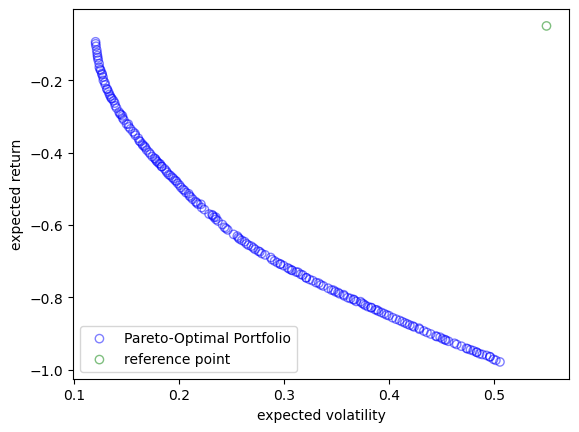

  Hypervolume@1800: 0.285013
Run 1/1 - LHS_SBX - 1900 gens


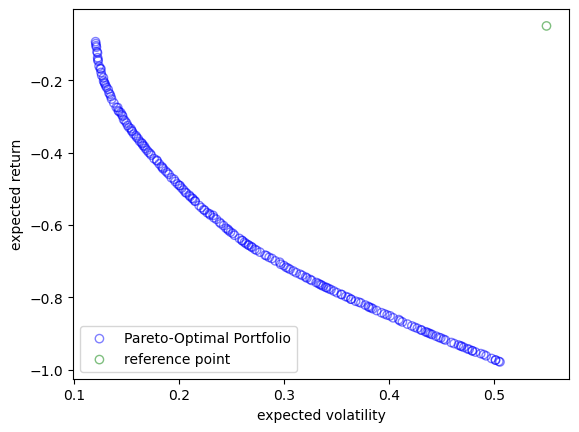

  Hypervolume@1900: 0.285142
Run 1/1 - LHS_SBX - 2000 gens


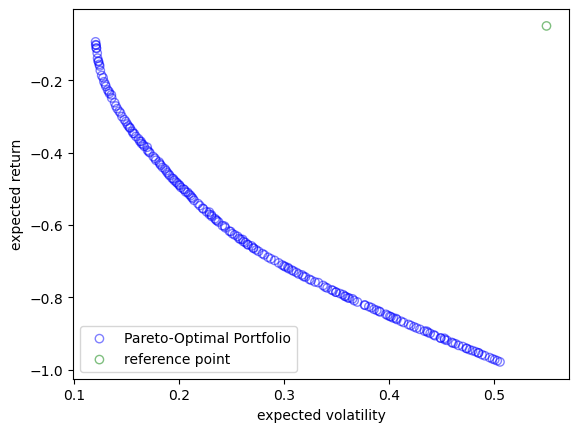

  Hypervolume@2000: 0.285027

Run 1/1 - LHS_TwoPt - 500 gens


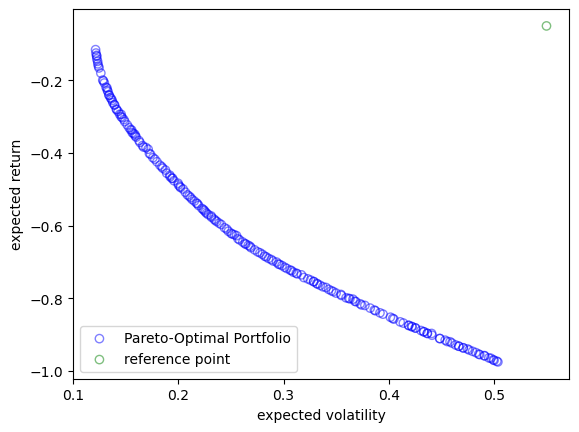

  Hypervolume@500: 0.284416
Run 1/1 - LHS_TwoPt - 600 gens


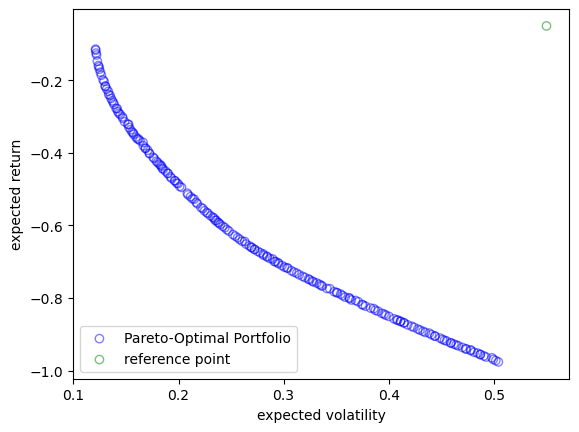

  Hypervolume@600: 0.284596
Run 1/1 - LHS_TwoPt - 700 gens


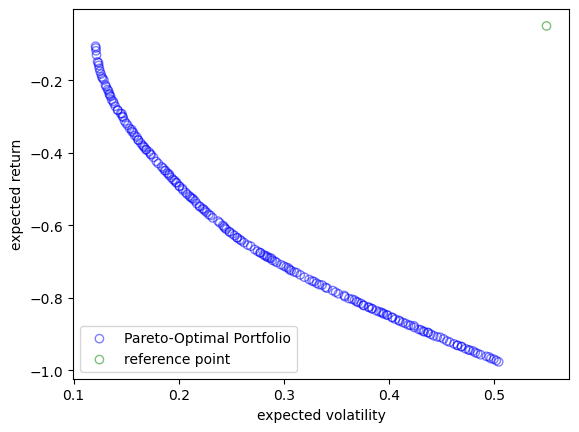

  Hypervolume@700: 0.284708
Run 1/1 - LHS_TwoPt - 800 gens


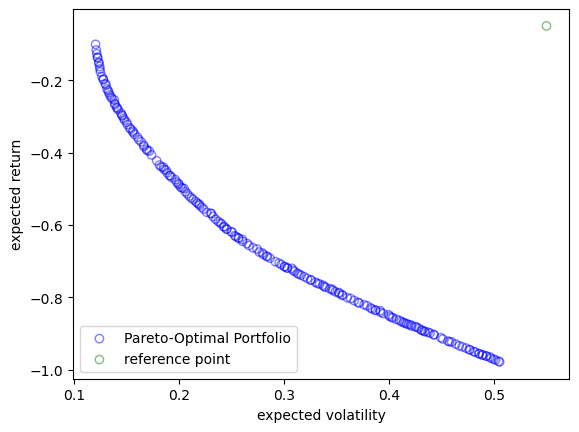

  Hypervolume@800: 0.284685
Run 1/1 - LHS_TwoPt - 900 gens


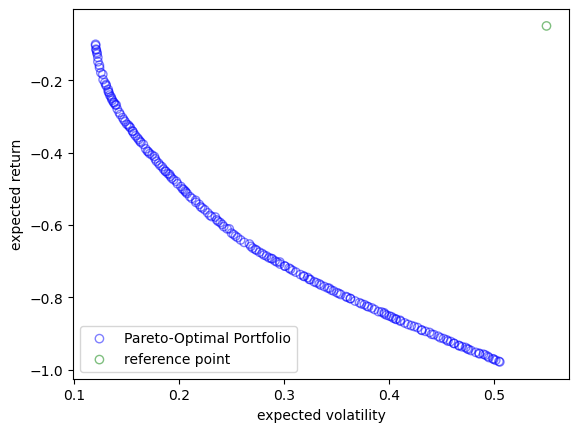

  Hypervolume@900: 0.284940
Run 1/1 - LHS_TwoPt - 1000 gens


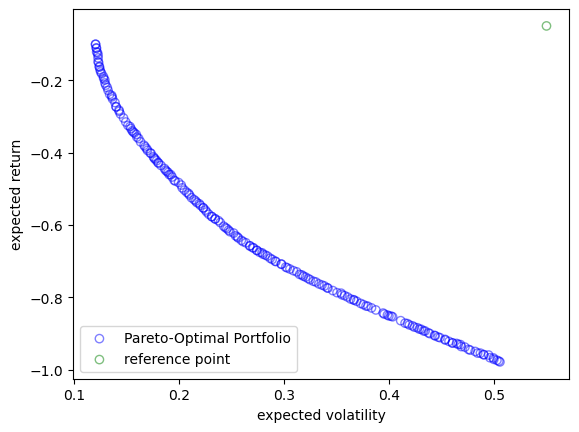

  Hypervolume@1000: 0.284749
Run 1/1 - LHS_TwoPt - 1100 gens


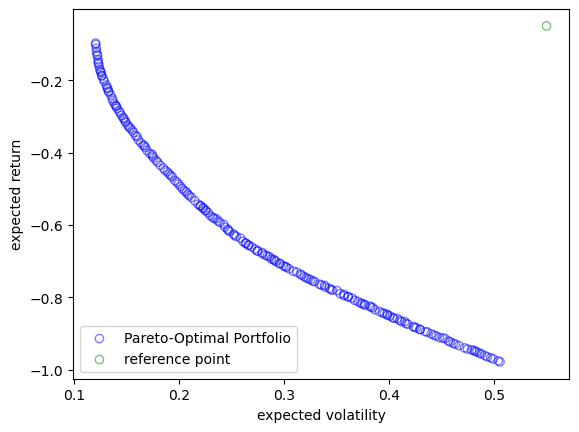

  Hypervolume@1100: 0.284966
Run 1/1 - LHS_TwoPt - 1200 gens


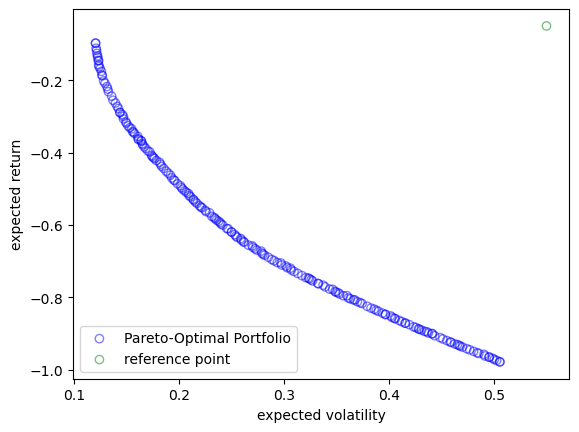

  Hypervolume@1200: 0.284995
Run 1/1 - LHS_TwoPt - 1300 gens


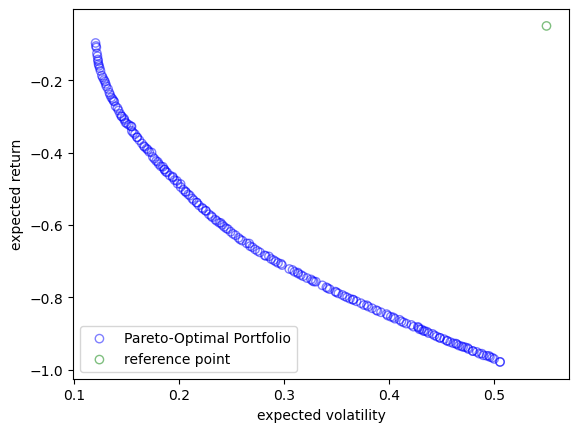

  Hypervolume@1300: 0.285048
Run 1/1 - LHS_TwoPt - 1400 gens


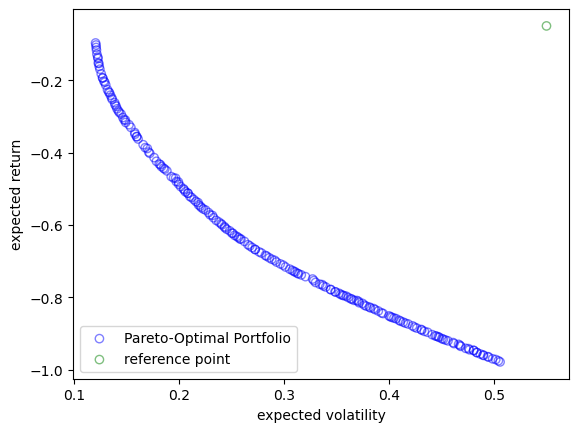

  Hypervolume@1400: 0.284983
Run 1/1 - LHS_TwoPt - 1500 gens


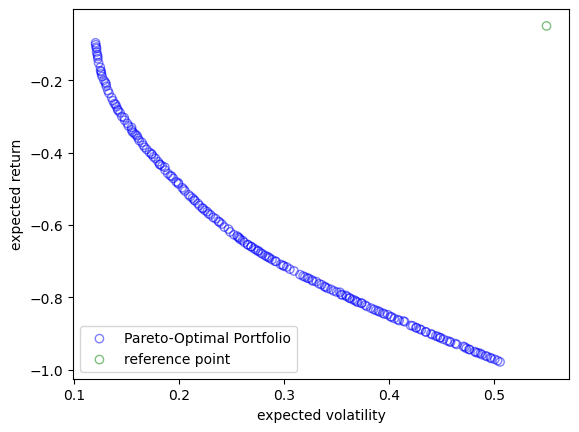

  Hypervolume@1500: 0.284990
Run 1/1 - LHS_TwoPt - 1600 gens


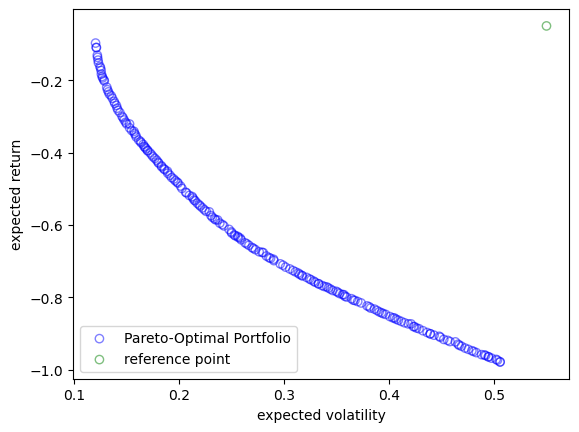

  Hypervolume@1600: 0.285013
Run 1/1 - LHS_TwoPt - 1700 gens


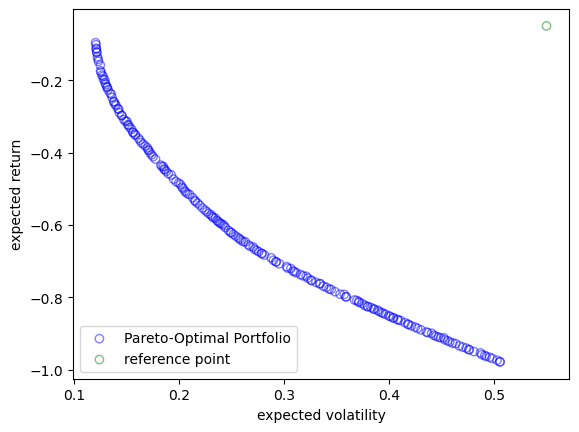

  Hypervolume@1700: 0.284913
Run 1/1 - LHS_TwoPt - 1800 gens


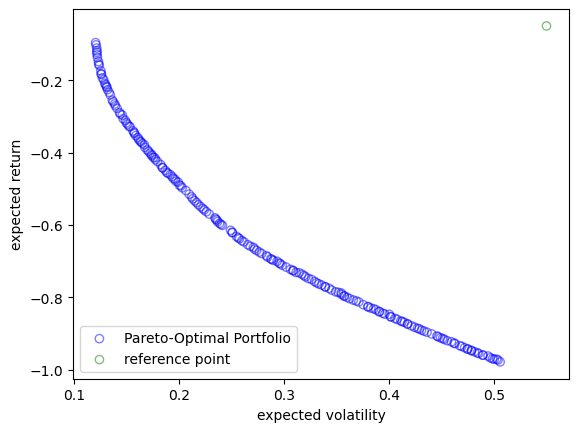

  Hypervolume@1800: 0.285013
Run 1/1 - LHS_TwoPt - 1900 gens


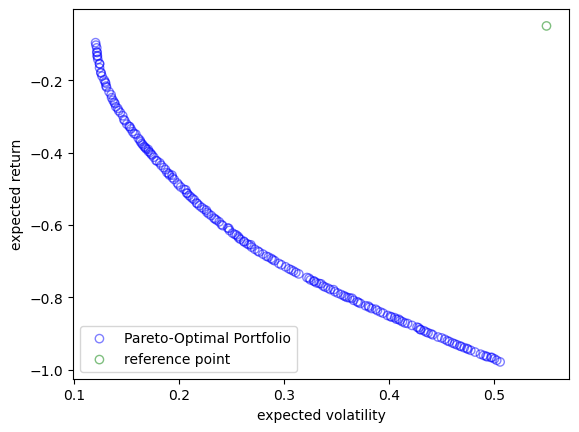

  Hypervolume@1900: 0.285079
Run 1/1 - LHS_TwoPt - 2000 gens


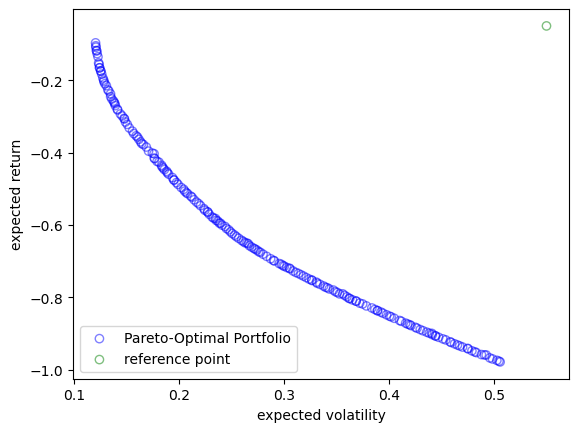

  Hypervolume@2000: 0.285159

Run 1/1 - LHS_Uniform - 500 gens


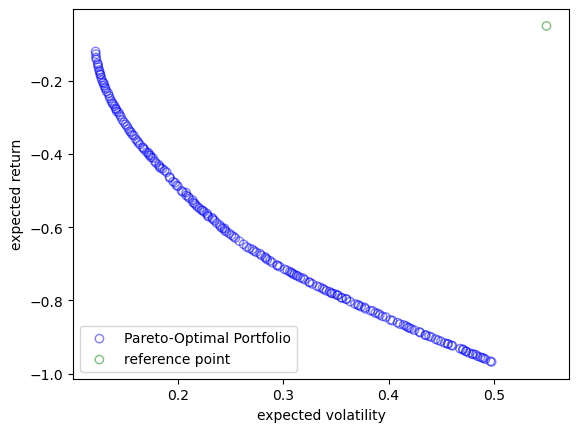

  Hypervolume@500: 0.284141
Run 1/1 - LHS_Uniform - 600 gens


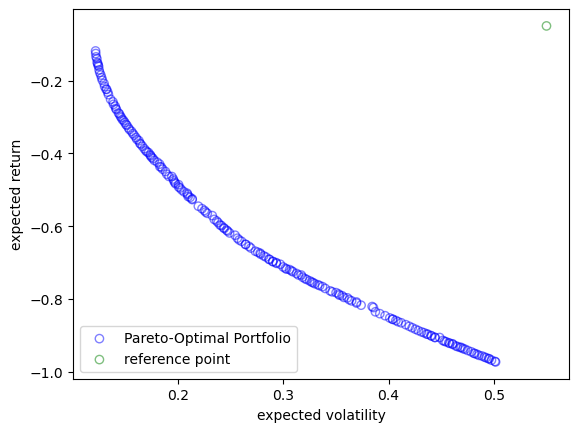

  Hypervolume@600: 0.284416
Run 1/1 - LHS_Uniform - 700 gens


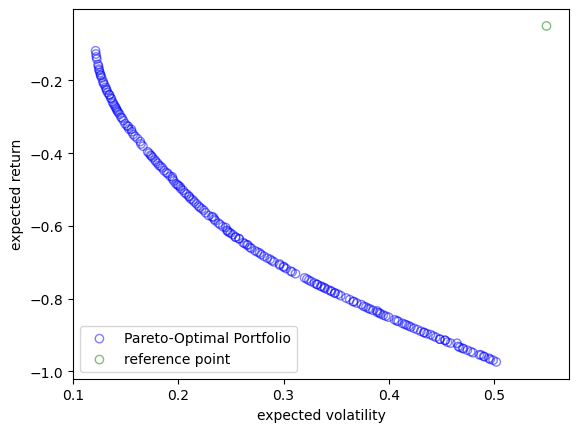

  Hypervolume@700: 0.284675
Run 1/1 - LHS_Uniform - 800 gens


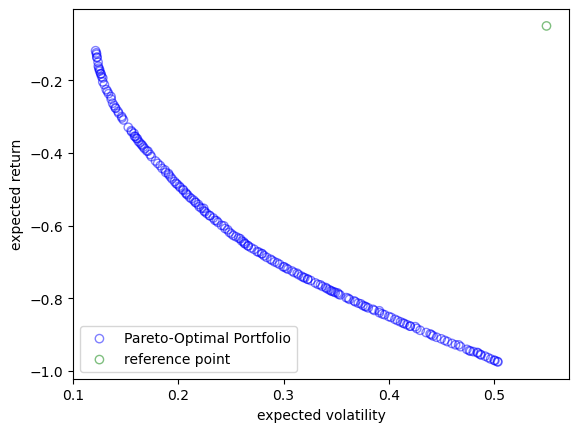

  Hypervolume@800: 0.284760
Run 1/1 - LHS_Uniform - 900 gens


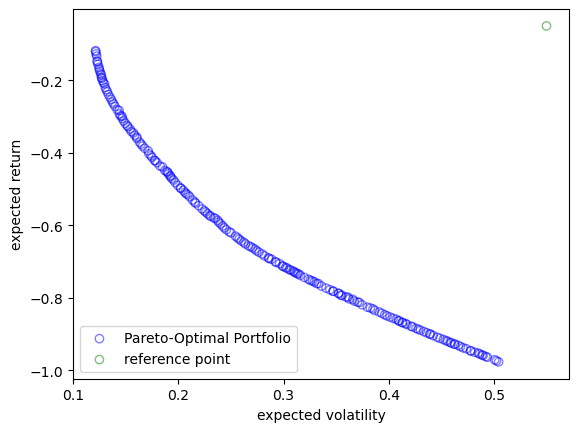

  Hypervolume@900: 0.284989
Run 1/1 - LHS_Uniform - 1000 gens


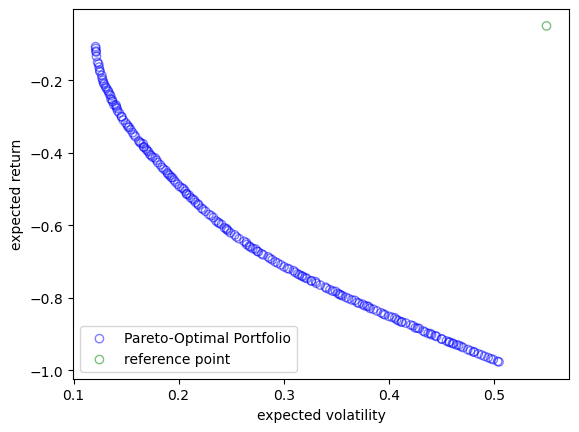

  Hypervolume@1000: 0.284977
Run 1/1 - LHS_Uniform - 1100 gens


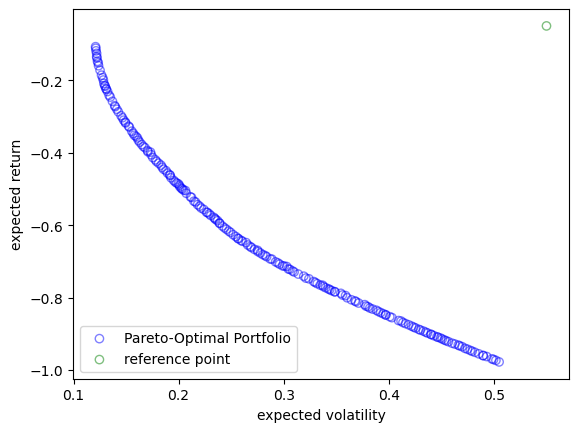

  Hypervolume@1100: 0.285026
Run 1/1 - LHS_Uniform - 1200 gens


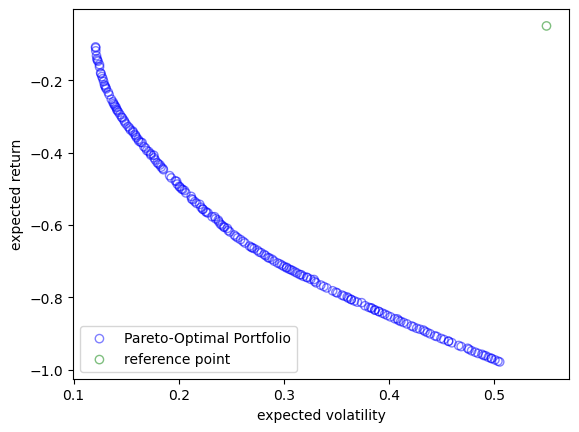

  Hypervolume@1200: 0.285027
Run 1/1 - LHS_Uniform - 1300 gens


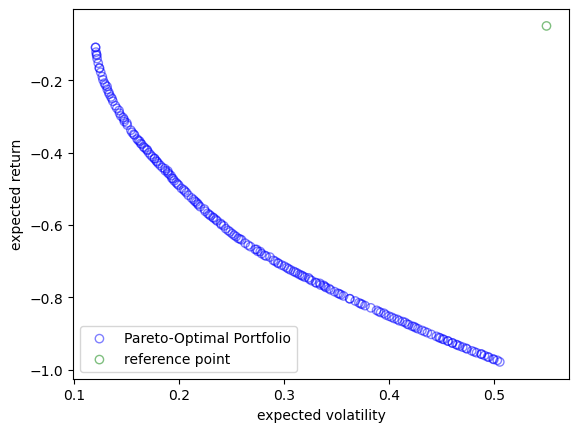

  Hypervolume@1300: 0.285148
Run 1/1 - LHS_Uniform - 1400 gens


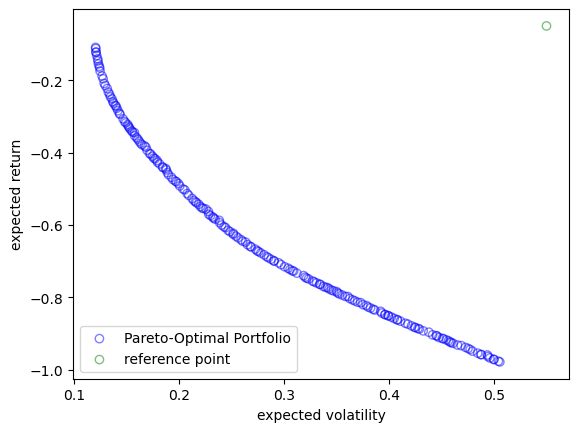

  Hypervolume@1400: 0.285004
Run 1/1 - LHS_Uniform - 1500 gens


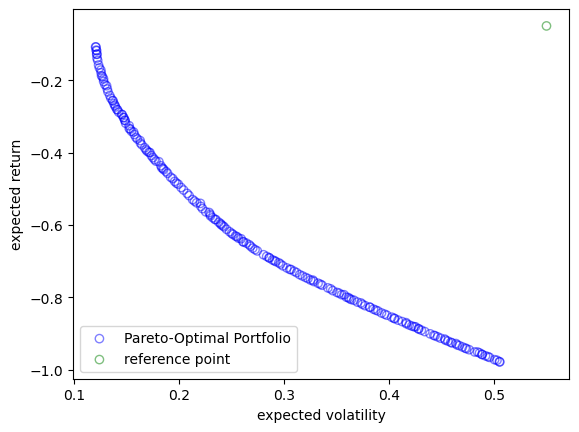

  Hypervolume@1500: 0.285088
Run 1/1 - LHS_Uniform - 1600 gens


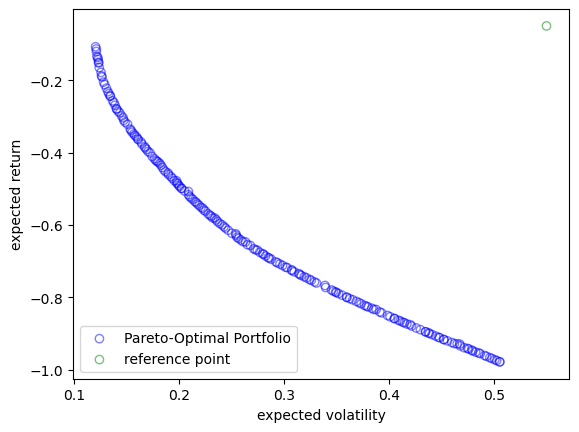

  Hypervolume@1600: 0.285139
Run 1/1 - LHS_Uniform - 1700 gens


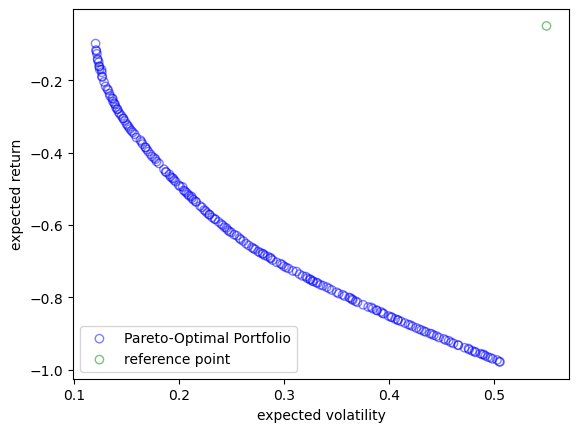

  Hypervolume@1700: 0.285088
Run 1/1 - LHS_Uniform - 1800 gens


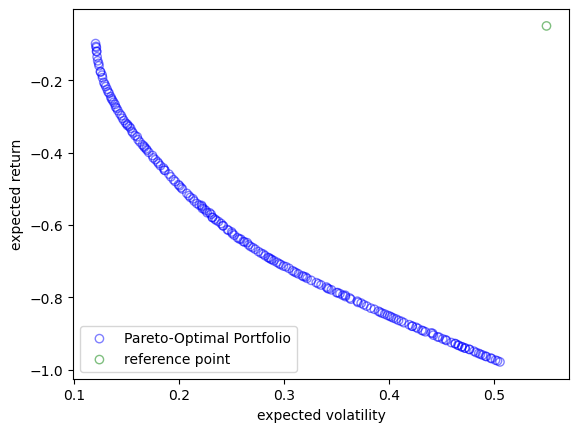

  Hypervolume@1800: 0.285176
Run 1/1 - LHS_Uniform - 1900 gens


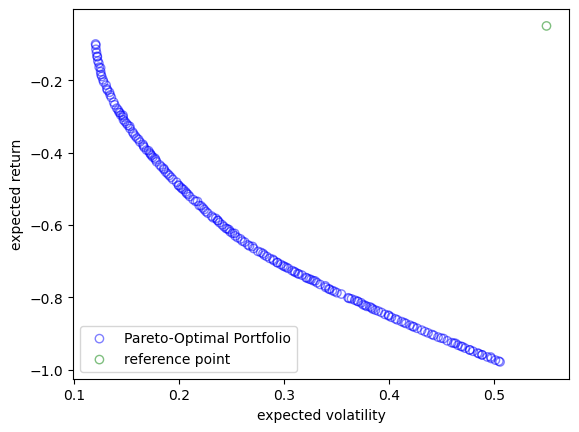

  Hypervolume@1900: 0.285225
Run 1/1 - LHS_Uniform - 2000 gens


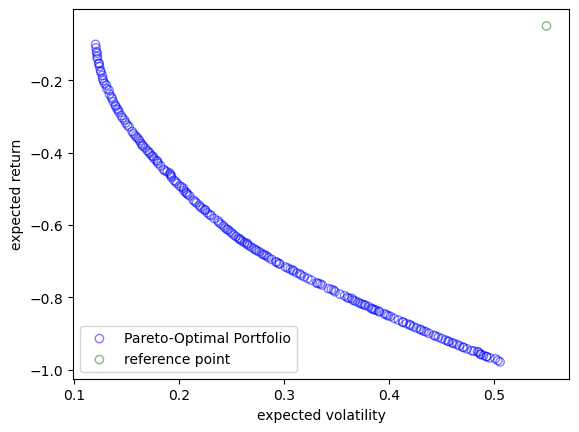

  Hypervolume@2000: 0.285250


BinaryRandom_SBX:
-----------------
  500 gens -> mean 0.284595, std 0.000000
  600 gens -> mean 0.284636, std 0.000000
  700 gens -> mean 0.284785, std 0.000000
  800 gens -> mean 0.284826, std 0.000000
  900 gens -> mean 0.284852, std 0.000000
  1000 gens -> mean 0.284793, std 0.000000
  1100 gens -> mean 0.284905, std 0.000000
  1200 gens -> mean 0.284791, std 0.000000
  1300 gens -> mean 0.284919, std 0.000000
  1400 gens -> mean 0.284930, std 0.000000
  1500 gens -> mean 0.284942, std 0.000000
  1600 gens -> mean 0.285022, std 0.000000
  1700 gens -> mean 0.285025, std 0.000000
  1800 gens -> mean 0.285131, std 0.000000
  1900 gens -> mean 0.285074, std 0.000000
  2000 gens -> mean 0.285069, std 0.000000

BinaryRandom_TwoPt:
-------------------
  500 gens -> mean 0.284975, std 0.000000
  600 gens -> mean 0.284992, std 0.000000
  700 gens -> mean 0.285005, std 0.000000
  800 gens -> mean 0.285046, std 0.000000
  900 gens -> mean 0.285088, std 0.000000

In [29]:
# Number of independent runs
test_time = 1

# Generate generation values from 500 to 2000 in steps of 100
generation_values = list(range(500, 2100, 100))  # [500, 600, 700, ..., 2000]

# Prepare storage for HV results - dynamically create keys for all generation values
test_results = {conf['name']: {str(gen): [] for gen in generation_values} for conf in configurations}

for run_idx in range(test_time):
    # Assuming these functions are defined elsewhere:    
    problem = PortfolioProblem(mu, cov)    

    for config in configurations:
        # Build the NSGA2 algorithm with chosen operators
        algorithm = NSGA2(
            pop_size=200,
            sampling=config['sampling'],
            crossover=config['crossover'],
            repair=PortfolioRepair()
        )

        # Test for each generation value
        for gen_count in generation_values:
            print(f"Run {run_idx+1}/{test_time} - {config['name']} - {gen_count} gens")
            
            result = minimize(
                problem,
                algorithm,
                termination=('n_gen', gen_count),
                seed=run_idx,
                verbose=False
            )

            X, F, sharpe = result.opt.get("X", "F", "sharpe")
            # F = F * [1, -1]  # Adjust for minimization/maximization
        
            hv = calculate_HV(F)
            test_results[config['name']][str(gen_count)].append(hv)
            print(f"  Hypervolume@{gen_count}: {hv:.6f}")

        print()  # Add blank line after each configuration

# After all runs, you can summarize results
def summarize_results(results_dict, gen_values):
    summary = {}
    for name, gens in results_dict.items():
        summary[name] = {}
        for gen in gen_values:
            gen_str = str(gen)
            summary[name][f'mean_HV_{gen}'] = np.nanmean(gens[gen_str])
            summary[name][f'std_HV_{gen}'] = np.nanstd(gens[gen_str])
    return summary

if __name__ == '__main__':
    summary = summarize_results(test_results, generation_values)
    
    # Print results in a formatted way
    for name, stats in summary.items():
        print(f"\n{name}:")
        print("-" * (len(name) + 1))
        for gen in generation_values:
            mean_key = f'mean_HV_{gen}'
            std_key = f'std_HV_{gen}'
            print(f"  {gen} gens -> mean {stats[mean_key]:.6f}, std {stats[std_key]:.6f}")
    
    # Optional: Create a summary table
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'Config':<20}", end="")
    for gen in generation_values:
        print(f"{gen:>10}", end="")
    print()
    print("-" * (20 + 10 * len(generation_values)))
    
    for name, stats in summary.items():
        print(f"{name:<20}", end="")
        for gen in generation_values:
            mean_val = stats[f'mean_HV_{gen}']
            print(f"{mean_val:>10.6f}", end="")
        print()

## Run the experiment gain money

In [136]:
# import libs
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

In [138]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = 0.95, hhi_limit=0.15, **kwargs):
        super().__init__(n_var=len(np.array(ticker)), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.returns_df = returns_df
        self.risk_free_rate = risk_free_rate
        self.VaR_confidence = VaR_confidence
        self.hhi_limit = hhi_limit        
        self.DAYS_PER_YEAR = 250
        self.z_alpha = norm.ppf(self.VaR_confidence)

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.asarray(x).flatten()
        
        exp_return = x @ self.mu
        volatility_daily = np.sqrt(x @ self.cov @ x)
        volatility_annual = volatility_daily * np.sqrt(self.DAYS_PER_YEAR)
        exp_return_annual = exp_return * self.DAYS_PER_YEAR

        # sharp ratio
        sharpe = (exp_return - self.risk_free_rate) / volatility_annual

        port_daily_ret = self.returns_df @ x #每日報酬
        
        '''
        # --- Calmar ratio ---
        
        # 若沒有回測區間太短會失敗，使用者自行確認 returns_df 的長度
        cum = np.cumprod(1 + port_daily_ret)
        running_max = np.maximum.accumulate(cum)
        running_max[running_max == 0] = 1e-6
        drawdowns = (running_max - cum) / running_max
        max_dd = drawdowns.max() if len(drawdowns) else 0.0
        calmar = np.inf if max_dd == 0 else exp_return_annual / max_dd
        '''
        
        # --- Herfindahl–Hirschman Index (HHI) 作多元化 ---
        hhi = np.sum(np.square(x))          # ∑ w_i²，1 = 全押單一資產
        diversity = 1 - hhi                 # 值愈大愈分散
        
        # --- Value at Risk ---
        var = -np.percentile(port_daily_ret, (1 - self.VaR_confidence) * 100)
        
        
        
        out["F"] = [volatility_annual, -exp_return]
        out["sharpe"] = sharpe
        # out["calmar"] = calmar
        out["diversity"] = diversity
        out["var"] = var

In [140]:
class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [142]:
from pymoo.indicators.hv import HV
from scipy.stats import norm

def calculate_expected_returns(current_data):
    ind_er = current_data.resample('YE').last().pct_change().mean()
    # print(ind_er)
    return ind_er

def calculate_covariance_matrix(current_data):
    cov_matrix = current_data.pct_change().apply(lambda x: np.log(1+x)).cov()
    # print(cov_matrix)
    return cov_matrix

def calculate_returns_df_matrix(current_data):
    returns_df = current_data.pct_change().dropna()
    return returns_df

def record_stock_price(stock_alloc, current_budget, price_day):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')  
    trade_date = fine_tune_data.index[price_day]
    # print(f'record stock price is {trade_date}')

    # extract stock price in trade date
    prices_series = fine_tune_data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')
    # print(f'Stock allocation: {stock_alloc}')    
    
    current_budget[0] = stock_alloc @ prices_array  
    
    # print(f'current budget is {current_budget[0]}')  

def execute_trades(stock_alloc, final_weight, current_budget, price_day):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')
    trade_date = fine_tune_data.index[price_day]
    # print(f'trade data is {trade_date}')

    # extract stock price in trade date
    prices_series = fine_tune_data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')
    # print(f'Stock allocation: {stock_alloc}')
    
    if not np.allclose(stock_alloc, np.zeros(len(ticker))):
        # print("you are here attention")
        current_budget[0] = stock_alloc @ prices_array   
    
    dollar_alloc = current_budget[0]*final_weight   

    # Element-wise division to get number of shares
    stock_alloc[:] = dollar_alloc / prices_array  # modifies caller's array
    # print(f'Stock allocation (shares): {stock_alloc}')

    
    # print(f'stock_alloc is {stock_alloc}')
    # print(f'current budget is {current_budget[0]}')

In [144]:
data_size = len(fine_tune_data)
test_time = 10  # Independent runs
test_period = 250
VaR_confidence = 0.95
hhi_limit = 0.25

# Storage
test_sharpe_results = {conf['name']: [] for conf in configurations}
test_diversity_results = {conf['name']: [] for conf in configurations}
test_min_var_results = {conf['name']: [] for conf in configurations}

for run_idx in range(test_time):
    print(f"Run {run_idx + 1}/{test_time}")

    for conf in configurations:    

        sharpe_current_budget = [1]
        sharpe_current_budget[0] = 1_000_000
        sharpe_stock_alloc = np.zeros(len(ticker)) 
         
        diversity_current_budget = [1]
        diversity_current_budget[0] = 1_000_000
        diversity_stock_alloc = np.zeros(len(ticker))  
        
        min_var_current_budget = [1]
        min_var_current_budget[0] = 1_000_000
        min_var_stock_alloc = np.zeros(len(ticker))  
        
        name = conf['name']
        print(f"{name}")
        
        for day in range(test_period):    
            print(f"Current day is: {day}")
            serach_day = data_size - (test_period-day)
            current_data = fine_tune_data.iloc[:serach_day] 

            if(day%20 != 0):  
                # print("you are doing sharpe")
                record_stock_price(sharpe_stock_alloc, sharpe_current_budget, serach_day)

                # print("you are doing diversity")
                record_stock_price(diversity_stock_alloc, diversity_current_budget, serach_day)

                # print("you are doing max_var")
                # record_stock_price(max_var_stock_alloc, max_var_current_budget, serach_day, max_var_budget_history, max_var_stock_alloc_history)

                # print("you are doing min_var")
                record_stock_price(min_var_stock_alloc, min_var_current_budget, serach_day)
                continue
        
            mu = calculate_expected_returns(current_data)
            cov = calculate_covariance_matrix(current_data)
            returns_df = calculate_returns_df_matrix(current_data)
            problem = PortfolioProblem(mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = VaR_confidence, hhi_limit=hhi_limit)

            algorithm = NSGA2(pop_size=200,
                    sampling=conf['sampling'],
                    crossover=conf['crossover'],
                    repair=PortfolioRepair())

            res = minimize( problem,
                    algorithm,
                    ('n_gen', 900),
                    seed=run_idx,
                    verbose=False) 
    
            # Get optimal portfolio weights
            X, F, sharpe, diversity, var = res.opt.get("X", "F", "sharpe", "diversity", "var")        
          
            # Select portfolio with maximum Sharpe ratio
            max_sharpe_idx = sharpe.argmax()            
            max_diversity_idx = diversity.argmax()
            # max_var_idx = var.argmax()
            min_var_idx = var.argmin()            
    
            sharpe_optimal_weights = X[max_sharpe_idx]            
            diversity_optimal_weights = X[max_diversity_idx]
            # max_var_optimal_weights = X[max_var_idx]
            min_var_optimal_weights = X[min_var_idx] 

            execute_trades(sharpe_stock_alloc, sharpe_optimal_weights, sharpe_current_budget, serach_day)  # Assume this function exists  
            execute_trades(diversity_stock_alloc, diversity_optimal_weights, diversity_current_budget, serach_day)  # Assume this function exists   
            # execute_trades(max_var_stock_alloc, max_var_optimal_weights, max_var_current_budget, serach_day)  # Assume this function exists    
            execute_trades(min_var_stock_alloc, min_var_optimal_weights, min_var_current_budget, serach_day)  # Assume this function exists

        name = conf['name']
        test_sharpe_results[name].append(sharpe_current_budget[0])
        test_diversity_results[name].append(diversity_current_budget[0])
        test_min_var_results[name].append(min_var_current_budget[0])

Run 1/10
BinaryRandom_SBX
Current day is: 0
Current day is: 1
Current day is: 2
Current day is: 3
Current day is: 4
Current day is: 5
Current day is: 6
Current day is: 7
Current day is: 8
Current day is: 9
Current day is: 10
Current day is: 11
Current day is: 12
Current day is: 13
Current day is: 14
Current day is: 15
Current day is: 16
Current day is: 17
Current day is: 18
Current day is: 19
Current day is: 20
Current day is: 21
Current day is: 22
Current day is: 23
Current day is: 24
Current day is: 25
Current day is: 26
Current day is: 27
Current day is: 28
Current day is: 29
Current day is: 30
Current day is: 31
Current day is: 32
Current day is: 33
Current day is: 34
Current day is: 35
Current day is: 36
Current day is: 37
Current day is: 38
Current day is: 39
Current day is: 40


KeyboardInterrupt: 

In [38]:
def summarize_results(results_dict):
    summary = {}
    for name, budget_list in results_dict.items():
        summary[name] = {
            'mean': np.nanmean(budget_list),
            'std': np.nanstd(budget_list)
        }
    return summary

if __name__ == '__main__':
    print(test_sharpe_results)
    print(test_diversity_results)
    print(test_min_var_results)
    sharpe_summary = summarize_results(test_sharpe_results)
    diversity_summary = summarize_results(test_diversity_results)
    min_var_summary = summarize_results(test_min_var_results)

    print("== Sharpe Summary ==")
    for name, stats in sharpe_summary.items():
        print(f"{name}: mean sharpe = {stats['mean']:.6f}, std = {stats['std']:.6f}")

    print("\n== Diversity Summary ==")
    for name, stats in diversity_summary.items():
        print(f"{name}: mean diversity = {stats['mean']:.6f}, std = {stats['std']:.6f}")

    print("\n== Min Var Summary ==")
    for name, stats in min_var_summary.items():
        print(f"{name}: mean min var = {stats['mean']:.6f}, std = {stats['std']:.6f}")

{'BinaryRandom_SBX': [1796594.0914320506, 1796563.0776278656, 1784556.6941154252, 1818854.741595052, 1793633.380074534, 1797811.246134052, 1799007.5153298336, 1797263.260734443, 1816000.875683052, 1804981.6146442043], 'BinaryRandom_TwoPt': [1801418.454611029, 1782109.3716330663, nan, 1792165.9583194698, nan, 1794238.587915565, 1804384.2483272667, 1816026.2835024581, 1818366.5469651872, 1805192.618869756], 'BinaryRandom_Uniform': [1805285.0500877444, 1818267.063537576, 1806730.5398676232, 1794090.398900529, 1780486.165713498, 1809683.4101901469, 1821827.8364265081, 1819891.4962605468, 1801505.7940042845, 1804852.1822970167], 'FloatRandom_SBX': [1794979.3502021662, 1781964.4440339978, 1789587.1724998988, 1802733.8200604229, 1792996.057292364, 1810024.8239696966, 1784660.2397352764, 1795474.8176446576, 1794142.1113385523, 1808216.475634549], 'FloatRandom_TwoPt': [1779082.0947350499, 1801053.484470974, 1816189.6882258498, 1795296.0712750393, 1781566.5140531077, 1801126.8999503246, 1795029.

# Solve problem with NSGA_II

## Install requirment

In [148]:
from IPython.display import clear_output

!pip install yfinance
!pip install fix_yahoo_finance
!pip install pymoo
clear_output()

# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [149]:
# import libs
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

## Get the data

In [151]:
# Import yfinance package
import yfinance as yf

# Set the start and end date
start_date = '2020-04-30' #'2020-04-30'
end_date = '2025-04-30'   #'2025-04-30'

ticker = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'TSLA', 'AVGO', 'GOOG', 'BRK-B',
          'JPM', 'LLY', 'V', 'XOM', 'UNH', 'MA', 'COST', 'WMT', 'HD', 'PG',
          'NFLX', 'JNJ', 'ABBV', 'CRM', 'BAC', 'ORCL', 'MRK', 'CVX', 'WFC', 'KO',
          'CSCO', 'ACN', 'NOW', 'TMO', 'MCD', 'IBM', 'AMD', 'DIS', 'PEP', 'LIN',
          'ABT', 'ISRG', 'PM', 'GE', 'ADBE', 'GS', 'QCOM', 'TXN', 'CAT', 'INTU']

# Get the data
data = yf.download(ticker, start_date, end_date, auto_adjust=False) # adding auto_adjust=False to get Adj Close

[*********************100%***********************]  50 of 50 completed


In [152]:
data = data['Adj Close']
# data

## NSGA2 SETTING

In [154]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = 0.95, hhi_limit=0.15, **kwargs):
        super().__init__(n_var=len(np.array(ticker)), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.returns_df = returns_df
        self.risk_free_rate = risk_free_rate
        self.VaR_confidence = VaR_confidence
        self.hhi_limit = hhi_limit        
        self.DAYS_PER_YEAR = 250
        self.z_alpha = norm.ppf(self.VaR_confidence)

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.asarray(x).flatten()
        
        exp_return = x @ self.mu
        volatility_daily = np.sqrt(x @ self.cov @ x)
        volatility_annual = volatility_daily * np.sqrt(self.DAYS_PER_YEAR)
        exp_return_annual = exp_return * self.DAYS_PER_YEAR

        # sharp ratio
        sharpe = (exp_return - self.risk_free_rate) / volatility_annual

        port_daily_ret = self.returns_df @ x #每日報酬
        
        '''
        # --- Calmar ratio ---
        
        # 若沒有回測區間太短會失敗，使用者自行確認 returns_df 的長度
        cum = np.cumprod(1 + port_daily_ret)
        running_max = np.maximum.accumulate(cum)
        running_max[running_max == 0] = 1e-6
        drawdowns = (running_max - cum) / running_max
        max_dd = drawdowns.max() if len(drawdowns) else 0.0
        calmar = np.inf if max_dd == 0 else exp_return_annual / max_dd
        '''
        
        # --- Herfindahl–Hirschman Index (HHI) 作多元化 ---
        hhi = np.sum(np.square(x))          # ∑ w_i²，1 = 全押單一資產
        diversity = 1 - hhi                 # 值愈大愈分散
        
        # --- Value at Risk ---
        var = -np.percentile(port_daily_ret, (1 - self.VaR_confidence) * 100)
        
        
        
        out["F"] = [volatility_annual, -exp_return]
        out["sharpe"] = sharpe
        # out["calmar"] = calmar
        out["diversity"] = diversity
        out["var"] = var

In [155]:
class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

## Needed function for running 

In [157]:
from pymoo.indicators.hv import HV
from scipy.stats import norm

def calculate_expected_returns(current_data):
    ind_er = current_data.resample('YE').last().pct_change().mean()
    # print(ind_er)
    return ind_er

def calculate_covariance_matrix(current_data):
    cov_matrix = current_data.pct_change().apply(lambda x: np.log(1+x)).cov()
    # print(cov_matrix)
    return cov_matrix

def calculate_returns_df_matrix(current_data):
    returns_df = current_data.pct_change().dropna()
    return returns_df

def record_stock_price(stock_alloc, current_budget, price_day, budget_history):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')  
    trade_date = data.index[price_day]
    # print(f'record stock price is {trade_date}')

    # extract stock price in trade date
    prices_series = data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')
    # print(f'Stock allocation: {stock_alloc}')    
    
    current_budget[0] = stock_alloc @ prices_array  
    
    budget_history.append(current_budget[0])
    # stock_alloc_history.append(stock_alloc.copy())
    # print(f'stock_alloc is {stock_alloc}')
    # print(f'current budget is {current_budget[0]}')  
        
def execute_trades(stock_alloc, final_weight, current_budget, price_day, budget_history, stock_alloc_history):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')
    trade_date = data.index[price_day]
    # print(f'trade data is {trade_date}')

    # extract stock price in trade date
    prices_series = data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')

    # print(f'Stock allocation: {stock_alloc}')

    
    if not np.allclose(stock_alloc, np.zeros(len(ticker))):
        current_budget[0] = stock_alloc @ prices_array
    
    
    # print(f'current budget is {current_budget[0]}')
    # print(f'final_weight is {final_weight}')
    dollar_alloc = current_budget[0]*final_weight
    # print(f'dollar_alloc is {dollar_alloc}')    

    # Element-wise division to get number of shares
    stock_alloc[:] = dollar_alloc / prices_array  # modifies caller's array
    # print(f'Stock allocation (shares): {stock_alloc}')

    budget_history.append(current_budget[0])
    stock_alloc_history.append(stock_alloc.copy())
    # print(f'test stock alloc {stock_alloc.copy()@ prices_array }')
    # print(f'stock_alloc is {stock_alloc}')
    # print(f'current budget is {current_budget[0]}')
    

## Run the whole process

Current day is: 0


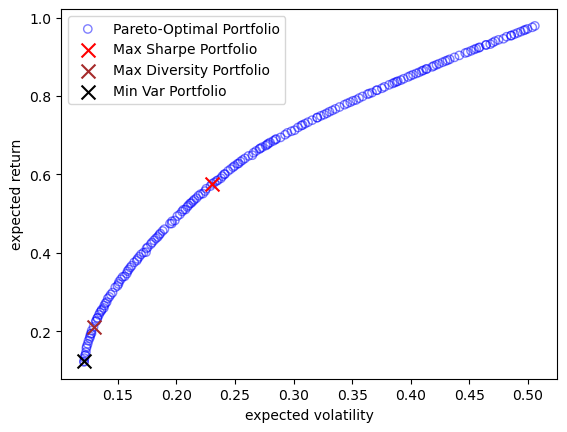

Current day is: 1
Current day is: 2
Current day is: 3
Current day is: 4
Current day is: 5
Current day is: 6
Current day is: 7
Current day is: 8
Current day is: 9
Current day is: 10
Current day is: 11
Current day is: 12
Current day is: 13
Current day is: 14
Current day is: 15
Current day is: 16
Current day is: 17
Current day is: 18
Current day is: 19
Current day is: 20


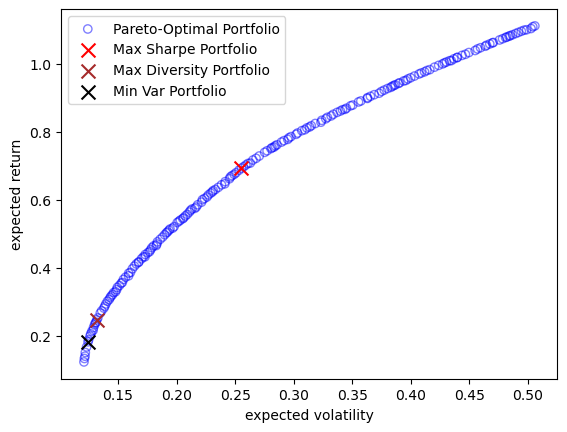

Current day is: 21
Current day is: 22
Current day is: 23
Current day is: 24
Current day is: 25
Current day is: 26
Current day is: 27
Current day is: 28
Current day is: 29
Current day is: 30
Current day is: 31
Current day is: 32
Current day is: 33
Current day is: 34
Current day is: 35
Current day is: 36
Current day is: 37
Current day is: 38
Current day is: 39
Current day is: 40


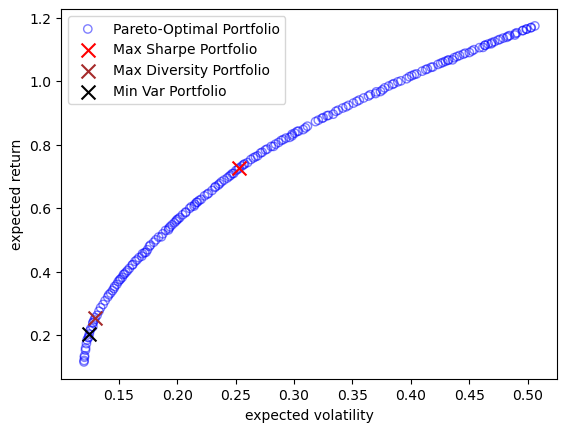

Current day is: 41
Current day is: 42
Current day is: 43
Current day is: 44
Current day is: 45
Current day is: 46
Current day is: 47
Current day is: 48
Current day is: 49
Current day is: 50
Current day is: 51
Current day is: 52
Current day is: 53
Current day is: 54
Current day is: 55
Current day is: 56
Current day is: 57
Current day is: 58
Current day is: 59
Current day is: 60


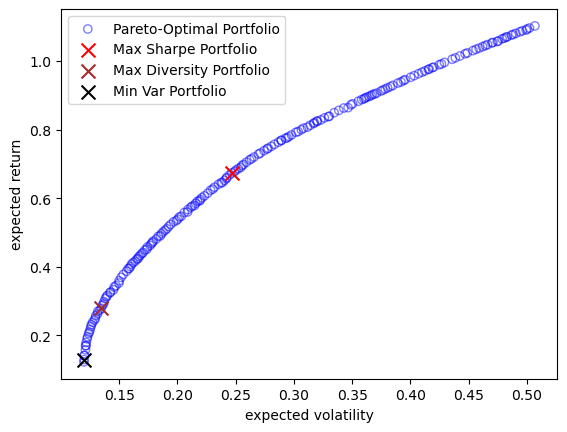

Current day is: 61
Current day is: 62
Current day is: 63
Current day is: 64
Current day is: 65
Current day is: 66
Current day is: 67
Current day is: 68
Current day is: 69
Current day is: 70
Current day is: 71
Current day is: 72
Current day is: 73
Current day is: 74
Current day is: 75
Current day is: 76
Current day is: 77
Current day is: 78
Current day is: 79
Current day is: 80


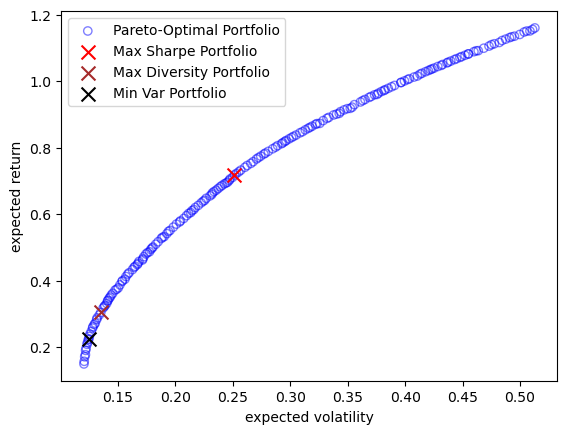

Current day is: 81
Current day is: 82
Current day is: 83
Current day is: 84
Current day is: 85
Current day is: 86
Current day is: 87
Current day is: 88
Current day is: 89
Current day is: 90
Current day is: 91
Current day is: 92
Current day is: 93
Current day is: 94
Current day is: 95
Current day is: 96
Current day is: 97
Current day is: 98
Current day is: 99
Current day is: 100


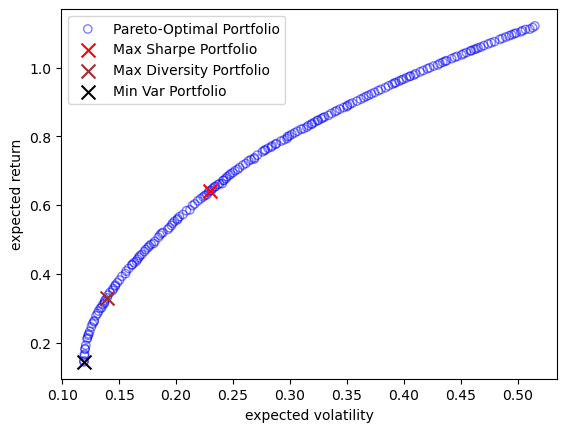

Current day is: 101
Current day is: 102
Current day is: 103
Current day is: 104
Current day is: 105
Current day is: 106
Current day is: 107
Current day is: 108
Current day is: 109
Current day is: 110
Current day is: 111
Current day is: 112
Current day is: 113
Current day is: 114
Current day is: 115
Current day is: 116
Current day is: 117
Current day is: 118
Current day is: 119
Current day is: 120


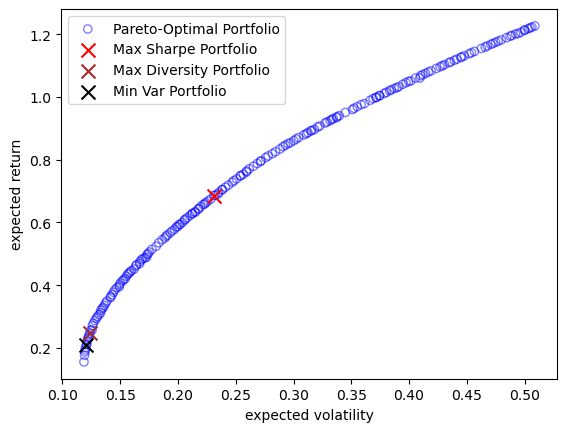

Current day is: 121
Current day is: 122
Current day is: 123
Current day is: 124
Current day is: 125
Current day is: 126
Current day is: 127
Current day is: 128
Current day is: 129
Current day is: 130
Current day is: 131
Current day is: 132
Current day is: 133
Current day is: 134
Current day is: 135
Current day is: 136
Current day is: 137
Current day is: 138
Current day is: 139
Current day is: 140


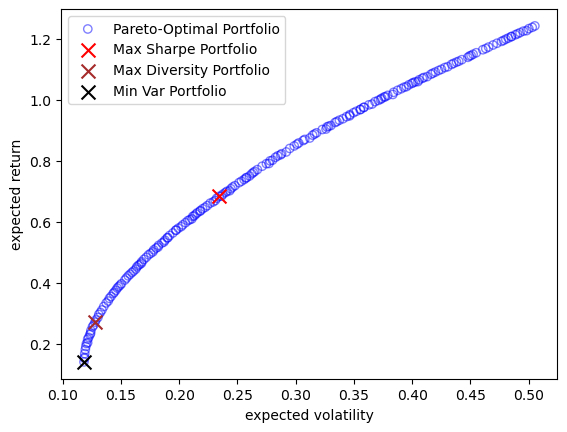

Current day is: 141
Current day is: 142
Current day is: 143
Current day is: 144
Current day is: 145
Current day is: 146
Current day is: 147
Current day is: 148
Current day is: 149
Current day is: 150
Current day is: 151
Current day is: 152
Current day is: 153
Current day is: 154
Current day is: 155
Current day is: 156
Current day is: 157
Current day is: 158
Current day is: 159
Current day is: 160


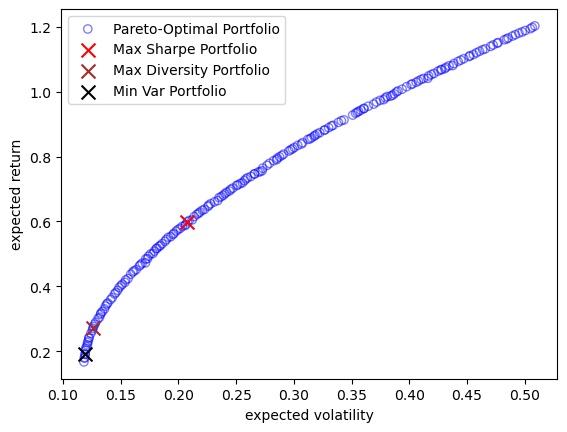

Current day is: 161
Current day is: 162
Current day is: 163
Current day is: 164
Current day is: 165
Current day is: 166
Current day is: 167
Current day is: 168
Current day is: 169
Current day is: 170
Current day is: 171
Current day is: 172
Current day is: 173
Current day is: 174
Current day is: 175
Current day is: 176
Current day is: 177
Current day is: 178
Current day is: 179
Current day is: 180


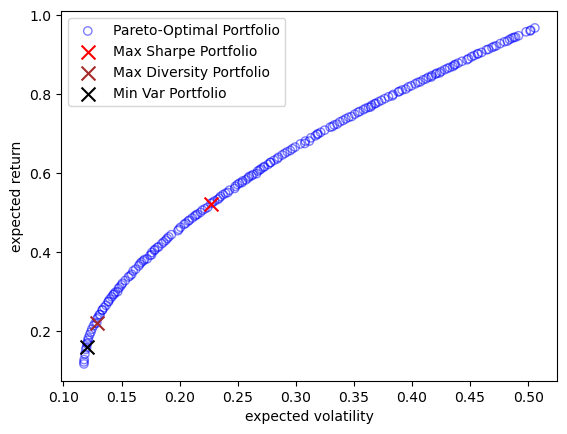

Current day is: 181
Current day is: 182
Current day is: 183
Current day is: 184
Current day is: 185
Current day is: 186
Current day is: 187
Current day is: 188
Current day is: 189
Current day is: 190
Current day is: 191
Current day is: 192
Current day is: 193
Current day is: 194
Current day is: 195
Current day is: 196
Current day is: 197
Current day is: 198
Current day is: 199
Current day is: 200


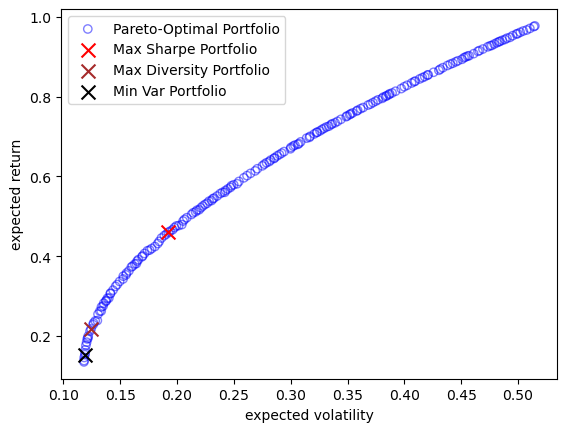

Current day is: 201
Current day is: 202
Current day is: 203
Current day is: 204
Current day is: 205
Current day is: 206
Current day is: 207
Current day is: 208
Current day is: 209
Current day is: 210
Current day is: 211
Current day is: 212
Current day is: 213
Current day is: 214
Current day is: 215
Current day is: 216
Current day is: 217
Current day is: 218
Current day is: 219
Current day is: 220


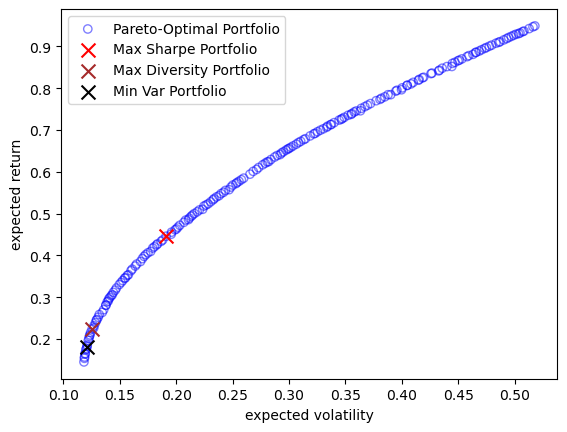

Current day is: 221
Current day is: 222
Current day is: 223
Current day is: 224
Current day is: 225
Current day is: 226
Current day is: 227
Current day is: 228
Current day is: 229
Current day is: 230
Current day is: 231
Current day is: 232
Current day is: 233
Current day is: 234
Current day is: 235
Current day is: 236
Current day is: 237
Current day is: 238
Current day is: 239
Current day is: 240


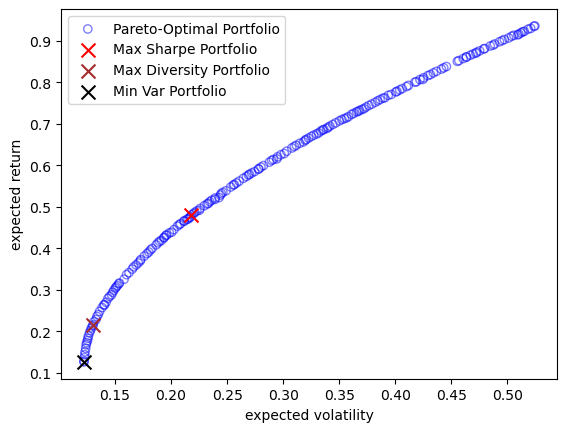

Current day is: 241
Current day is: 242
Current day is: 243
Current day is: 244
Current day is: 245
Current day is: 246
Current day is: 247
Current day is: 248
Current day is: 249


In [159]:
'''
%%time
for config in configurations:
    print(f"\nRunning configuration: {config['name']}")
'''
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.sampling.rnd import FloatRandomSampling, BinaryRandomSampling

results = {}
sharpe_portfolio_history = []
# calmar_portfolio_history = []
diversity_portfolio_history = []
# max_var_portfolio_history = []
min_var_portfolio_history = []
data_size = len(data)

sharpe_current_budget = [1]
sharpe_current_budget [0] = 1_000_000
sharpe_stock_alloc = np.zeros(len(ticker))  
# calmar_current_budget = 1_000_000
# calmar_stock_alloc = np.zeros(len(ticker))  
diversity_current_budget = [1]
diversity_current_budget[0] = 1_000_000
diversity_stock_alloc = np.zeros(len(ticker))  
# max_var_current_budget = 1_000_000
# max_var_stock_alloc = np.zeros(len(ticker))  
min_var_current_budget = [1]
min_var_current_budget[0] = 1_000_000
min_var_stock_alloc = np.zeros(len(ticker))  

sharpe_budget_history = []
sharpe_stock_alloc_history = []
# calmar_budget_history = []
# calmar_stock_alloc_history = []
diversity_budget_history = []
diversity_stock_alloc_history = []
# max_var_budget_history = []
# max_var_stock_alloc_history = []
min_var_budget_history = []
min_var_stock_alloc_history = []

test_period = 250

VaR_confidence = 0.95
hhi_limit = 0.25
# 這裡的 hhi_limit 會影響到多元化的程度，hhi_limit 越小，越分散

for day in range(test_period):    
    print(f"Current day is: {day}")
    serach_day = data_size - (test_period-day)
    current_data = data.iloc[:serach_day] 

    if(day%20 != 0): 
        # print("you are doing sharpe")
        record_stock_price(sharpe_stock_alloc, sharpe_current_budget, serach_day, sharpe_budget_history)

        # print("you are doing diversity")
        record_stock_price(diversity_stock_alloc, diversity_current_budget, serach_day, diversity_budget_history)

        # print("you are doing max_var")
        # record_stock_price(max_var_stock_alloc, max_var_current_budget, serach_day, max_var_budget_history, max_var_stock_alloc_history)

        # print("you are doing min_var")
        record_stock_price(min_var_stock_alloc, min_var_current_budget, serach_day, min_var_budget_history)
        continue

    # print(current_data)
    mu = calculate_expected_returns(current_data)
    cov = calculate_covariance_matrix(current_data)
    returns_df = calculate_returns_df_matrix(current_data)
    problem = PortfolioProblem(mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = VaR_confidence, hhi_limit=hhi_limit)
    # print(current_data)
    
    '''
    algorithm = NSGA2(repair=PortfolioRepair(),
                      sampling = config['sampling'],
                      crossover=config['crossover'])
    '''
    
    algorithm = NSGA2(pop_size=200,
                      sampling=BinaryRandomSampling(),
                      crossover=UniformCrossover(),
                      repair=PortfolioRepair())
    
    res = minimize(problem,
                   algorithm,
                   ('n_gen', 900),
                   seed=1,
                   verbose=False) 

    # Get optimal portfolio weights
    X, F, sharpe, diversity, var = res.opt.get("X", "F", "sharpe", "diversity", "var")
    F = F * [1, -1]  # Adjust for minimization/maximization    
    

    # Select portfolio with maximum Sharpe ratio
    max_sharpe_idx = sharpe.argmax()
    # max_calmar_idx = calmar.argmax()
    max_diversity_idx = diversity.argmax()
    # max_var_idx = var.argmax()
    min_var_idx = var.argmin()

    
    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    # plt.scatter(cov.diagonal() ** 0.5 * np.sqrt(250.0), mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe_idx, 0], F[max_sharpe_idx, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    # plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.scatter(F[max_diversity_idx, 0], F[max_diversity_idx, 1], marker="x", s=100, color="brown", label="Max Diversity Portfolio")
    # plt.scatter(F[max_var_idx, 0], F[max_var_idx, 1], marker="x", s=100, color="yellow", label="Max Var Portfolio")
    plt.scatter(F[min_var_idx, 0], F[min_var_idx, 1], marker="x", s=100, color="black", label="Min Var Portfolio")
    # plt.scatter(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0), x.T @ mu, marker="*", s=100, color="green", label="Equal weights")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()
    
    
    sharpe_optimal_weights = X[max_sharpe_idx]
    # calmar_optimal_weights = X[max_calmar_idx]
    diversity_optimal_weights = X[max_diversity_idx]
    # max_var_optimal_weights = X[max_var_idx]
    min_var_optimal_weights = X[min_var_idx]

    # calculate HV
    # HVindex = calculate_HV(F)

    '''
    # Add other indicators (f1, ..., fk) for daily allocation
    additional_indicators = calculate_technical_indicators(current_data)  # Assume this function exists
    final_weights = adjust_weights_with_indicators(optimal_weights, additional_indicators)
    '''


    
    # Make investment with adjusted weights
    # print("you are doing sharpe")
    execute_trades(sharpe_stock_alloc, sharpe_optimal_weights, sharpe_current_budget, serach_day, sharpe_budget_history, sharpe_stock_alloc_history)  # Assume this function exists
    

    # print("you are doing calmar")
    # calmar_daily_return = calmar_execute_trades(calmar_stock_alloc, calmar_optimal_weights, calmar_current_budget, serach_day, calmar_budget_history, calmar_stock_alloc_history)  # Assume this function exists
    # calmar_portfolio_history.append(calmar_daily_return)

    # print("you are doing diversity")
    execute_trades(diversity_stock_alloc, diversity_optimal_weights, diversity_current_budget, serach_day, diversity_budget_history, diversity_stock_alloc_history)  # Assume this function exists
    
    # print("you are doing max_var")
    # execute_trades(max_var_stock_alloc, max_var_optimal_weights, max_var_current_budget, serach_day, max_var_budget_history, max_var_stock_alloc_history)  # Assume this function exists

    # print("you are doing min_var")
    execute_trades(min_var_stock_alloc, min_var_optimal_weights, min_var_current_budget, serach_day, min_var_budget_history, min_var_stock_alloc_history)  # Assume this function exists

In [190]:
print("--------------------")
print(sharpe_budget_history)
print("--------------------")
print(sharpe_stock_alloc_history)
# print(np.round(sharpe_stock_alloc_history, 5))
print("--------------------")
print(diversity_budget_history)
print("--------------------")
print(diversity_stock_alloc_history)
# print(np.round(diversity_stock_alloc_history, 5))
print("--------------------")
print(min_var_budget_history)
print("--------------------")
print(min_var_stock_alloc_history)
# print(np.round(min_var_stock_alloc_history, 5))

--------------------
[1000000, 981071.0033077358, 982083.0124781602, 982351.0265573428, 1009803.9230840277, 1009699.8229332643, 1007494.3503354246, 1005691.7472424523, 1002706.0394632977, 1002308.3985731029, 1009599.8915142219, 1035708.9122460795, 1025405.7177092242, 1022544.1581855135, 1033667.1556070128, 1042673.0308661924, 1035866.82998411, 1064548.4272055074, 1072350.0531644234, 1099241.7995487335, 1100296.5294086337, 1087997.1844799127, 1095330.4770091623, 1112274.716380523, 1113834.859742909, 1135532.8633282955, 1134867.208996867, 1138332.8583494907, 1149953.5989049894, 1144758.6443578873, 1157696.9641545573, 1177954.8082431834, 1181290.3323736999, 1181218.6821268336, 1203127.5185557446, 1189125.5045861013, 1171041.8582298069, 1151594.1948204343, 1187171.702619178, 1186838.6998452123, 1183475.5905879945, 1180656.7299345504, 1187403.73856882, 1175941.5087701227, 1192039.7185473235, 1188538.350266271, 1195208.223077428, 1210143.657112156, 1228362.7971317298, 1203535.0849808522, 121

#### for i in range(len(stock_alloc_history)):
    print(stock_alloc_history[i]) 

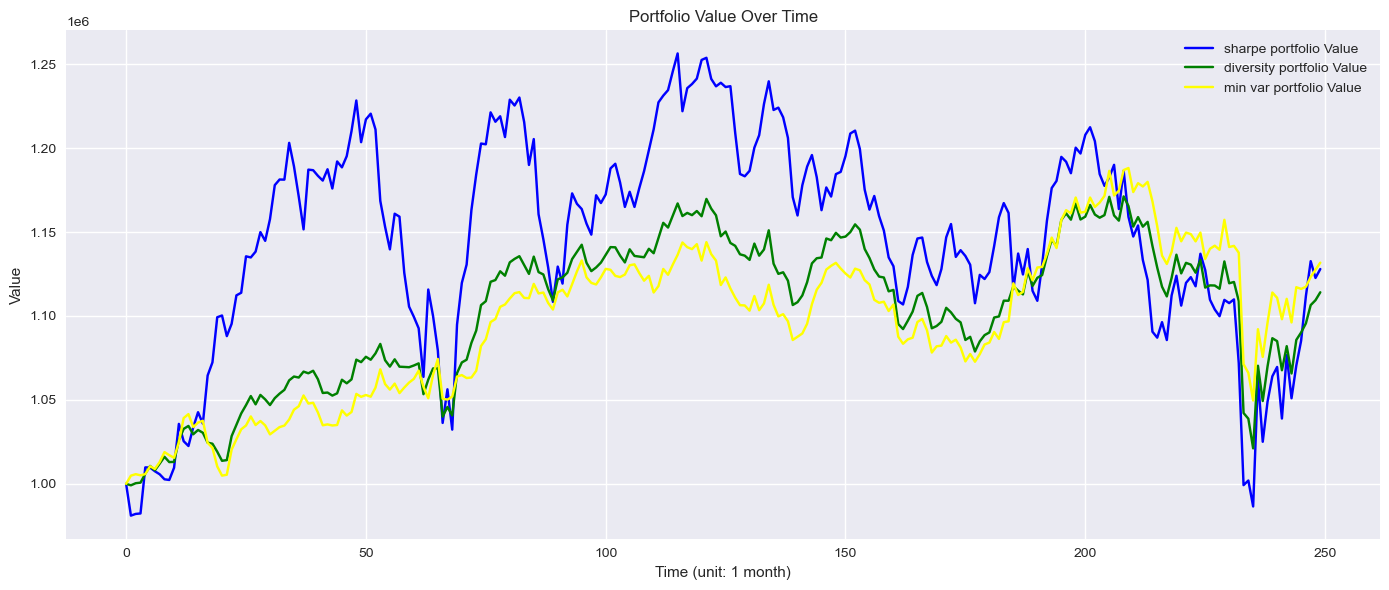

In [266]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(sharpe_budget_history, label="sharpe portfolio Value", color='blue')
# plt.plot(calmar_budget_history, label="calmar Portfolio Value", color='red')
plt.plot(diversity_budget_history, label="diversity portfolio Value", color='green')
# plt.plot(max_var_budget_history, label="max var portfolio Value", color='peru')
plt.plot(min_var_budget_history, label="min var portfolio Value", color='yellow')
plt.title("Portfolio Value Over Time")
plt.xlabel("Time (unit: 1 month)")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Compare results
for name, res in results.items():
    print(f"\nThe result of {name} is as follows\n")
    X, F, sharpe = res.opt.get("X", "F", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    '''
    # equal weights
    x = np.zeros((len(ticker), 1))
    x = x + 1.0/len(x)

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5 * np.sqrt(250.0), mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.scatter(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0), x.T @ mu, marker="*", s=100, color="green", label="Equal weights")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()
    '''
    x = X[max_sharpe].T

    print("Best Sharpe: \nReturn     = ", x.T @ mu)
    print("Volatility = ", np.sqrt(x.T @ cov @ x) * np.sqrt(250.0))
    print("sharpo ratio = ", (x.T @ mu - 0.02)/(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0)))


Allocation With Best Sharpe
WMT   1398.00986751
JNJ   1365.03975257
MRK   1206.76714483
PG    797.7410344
XOM   481.06103549
MCD   478.99930601
KO    450.23563815
PM    443.35386031
ABBV  280.01181733
ORCL  226.84705316
GOOG  222.82671575
CVX   88.08724405
UNH   51.52574097
COST  34.32465951
IBM   33.07073871
AVGO  26.54555946
NVDA  20.42570981
NFLX  19.43045094
BRK-B 12.69126323
LLY   8.39042971
HD    6.40760108
AAPL  0.0
ABT   0.0
ACN   0.0
ADBE  0.0
AMD   0.0
AMZN  0.0
BAC   0.0
CAT   0.0
CRM   0.0
CSCO  0.0
DIS   0.0
GE    0.0
GOOGL 0.0
GS    0.0
INTU  0.0
ISRG  0.0
JPM   0.0
LIN   0.0
MA    0.0
META  0.0
MSFT  0.0
NOW   0.0
PEP   0.0
QCOM  0.0
TMO   0.0
TSLA  0.0
TXN   0.0
V     0.0
WFC   0.0


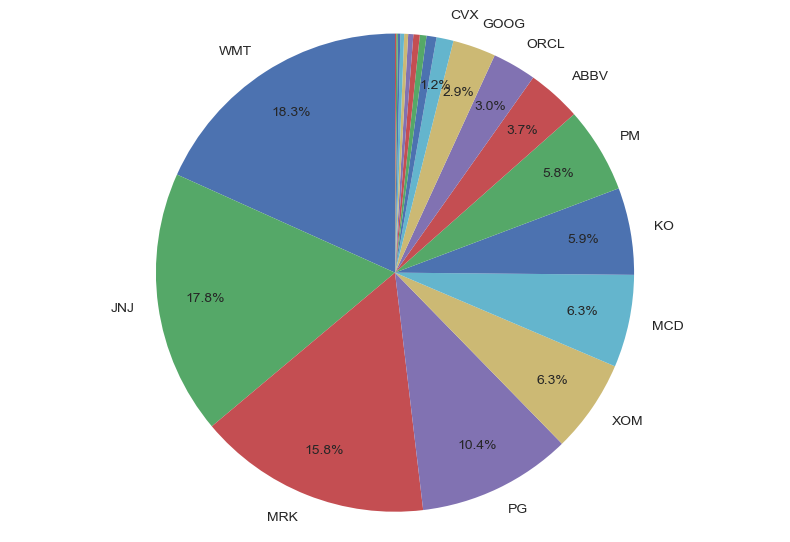

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import operator

weight = np.array([   0.        ,  280.01181733,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   26.54555946,
          0.        ,   12.69126323,    0.        ,   34.32465951,
          0.        ,    0.        ,   88.08724405,    0.        ,
          0.        ,  222.82671575,    0.        ,    0.        ,
          6.40760108,   33.07073871,    0.        ,    0.        ,
       1365.03975257,    0.        ,  450.23563815,    0.        ,
          8.39042971,    0.        ,  478.99930601,    0.        ,
       1206.76714483,    0.        ,   19.43045094,    0.        ,
         20.42570981,  226.84705316,    0.        ,  797.7410344 ,
        443.35386031,    0.        ,    0.        ,    0.        ,
          0.        ,   51.52574097,    0.        ,    0.        ,
       1398.00986751,  481.06103549])

allocation = {name: w for name, w in zip(data, weight)}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} {w}")

# Extract labels and sizes for the pie chart
# labels = list(allocation.keys())
# sizes = list(allocation.values())

# Plot pie chart
col_name = []
w1 = []
for name, w in allocation:
    col_name.append(name)
    w1.append(w)

total = sum(w1)

def make_autopct(threshold=1):
    def autopct(pct):
        return f'{pct:.1f}%' if pct >= threshold else ''
    return autopct

# Filter labels: hide if percentage < 1%
def filter_labels(w1, col_name, threshold=1):
    return [label if (w / total * 100) >= threshold else '' for label, w in zip(col_name, w1)]

fig1, ax1 = plt.subplots()
ax1.pie(
    w1,
    labels=filter_labels(w1, col_name, threshold=1),
    autopct=make_autopct(threshold=1),
    shadow=False,
    startangle=90,
    labeldistance=1.1,
    pctdistance=0.8
)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [53]:
for al in allocation:
    if al[1] <= 1e-2:
        allocation.remove(al)

col_name = []
w1 = []
for name, w in allocation:
    col_name.append(name)
    w1.append(w)
    
fig1, ax1 = plt.subplots()
ax1.pie(w1, labels=col_name, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

NameError: name 'allocation' is not defined

In [55]:
x = np.zeros((len(ticker), 1))
x = x + 1.0/len(x)

print("For equal weights: \nReturn     = ", (x.T @ mu)[0])
print("Volatility = ", (np.sqrt(x.T @ cov @ x) * np.sqrt(250.0))[0][0])

For equal weights: 
Return     =  0.11474887960744226
Volatility =  0.194630738676453


In [57]:
x = X[max_sharpe].T

print("Best Sharpe: \nReturn     = ", x.T @ mu)
print("Volatility = ", np.sqrt(x.T @ cov @ x) * np.sqrt(250.0))

NameError: name 'X' is not defined

In [64]:
import numpy as np
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair

class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        super().__init__(
            n_var=len(mu),
            n_obj=2,
            xl=0.0,
            xu=1.0,
            **kwargs
        )
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk   = np.sqrt(x.T @ self.cov @ x) * np.sqrt(250.0)
        sharpe     = (exp_return - self.risk_free_rate) / exp_risk
        out["F"]   = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

# Compute mu, cov from your data
mu  = calculate_expected_returns(current_data)
cov = calculate_covariance_matrix(current_data)

# Problem definition
problem = PortfolioProblem(mu, cov)

# Reference directions for MOEA/D 
ref_dirs = get_reference_directions("uniform", 2, n_partitions=100)

# MOEA/D algorithm setup
algorithm = MOEAD(
    ref_dirs,
    n_neighbors=20,
    prob_neighbor_mating=0.7,
    repair=PortfolioRepair()
)

# Run optimization
res = minimize(problem, algorithm, seed=1, verbose=False)

# Extract and select optimal portfolio
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe_idx = sharpe.argmax()
optimal_weights = X[max_sharpe_idx]

# Hypervolume (optional)
HVindex = calculate_HV(F)


C:\Users\kaomi\AppData\Local\Temp\ipykernel_18768\4236682315.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ind_er = current_data.resample('Y').last().pct_change().mean()


HV 0.022752022831910097
